In [135]:
import gymnasium as gym
import numpy as np
from gymnasium import spaces
from stable_baselines3 import A2C, PPO, DQN
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.policies import ActorCriticPolicy
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import torch.nn as nn
import torch

from custom_environment import GridEnvCNN, GridEnvMLP
from custom_policy import CustomCNN, CustomCNNPolicy

In [134]:
class ActionStoreCallback(BaseCallback):
    def __init__(self):
        super().__init__()
        self.actions = []

    def _on_step(self):
        self.actions.append(self.locals["actions"])
        return True
    


def plot_action_histogram(callback):   
    actions_array = np.array(callback.actions).flatten()
    plt.hist(actions_array, label = 'Action Histogram')
    plt.xlabel('Actions')
    plt.ylabel('n')
    plt.xticks([0,1,2,3], ['up', 'down', 'left', 'right'])
    plt.show()

# 16x16

1.0


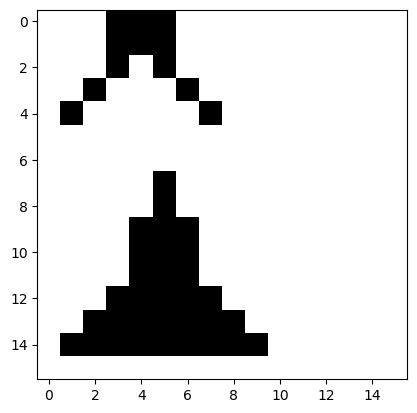

In [3]:
loaded = np.load('../environment_generation/environments/environments_16_2_10_1.npy')
loaded.shape

grid = loaded[9]
print(grid.max())
plt.imshow(grid, cmap='binary')

## random start, fixed goal, fixed empty env

In [ ]:
# random start point
from stable_baselines3.common.vec_env import DummyVecEnv
empty_grid = np.zeros((16, 16))
goal = (15,15)
max_steps = 32
lr = 2.5e-4
total_timesteps=200000
ent_coef = 0.01


def make_env():
    def _init():
        while True:
            start_x = np.random.choice(range(16))
            start_y = np.random.choice(range(16))
            start = (start_y, start_x)
            if start != goal:
                break
        return GridEnvMLP(empty_grid, start, goal, max_steps)
    return _init


env = DummyVecEnv([make_env() for _ in range(16)])

batch_size = 64
callback = ActionStoreCallback()
model = PPO("MlpPolicy", env, tensorboard_log="./rl_agent_static_tensorboard/", learning_rate=lr, batch_size=batch_size, n_steps=1024, device='cpu', ent_coef= ent_coef).learn(total_timesteps=total_timesteps, callback=callback, progress_bar=True)


 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212,992/200,000  [ 0:01:28 < 0:00:00 , 1,651 it/s ]

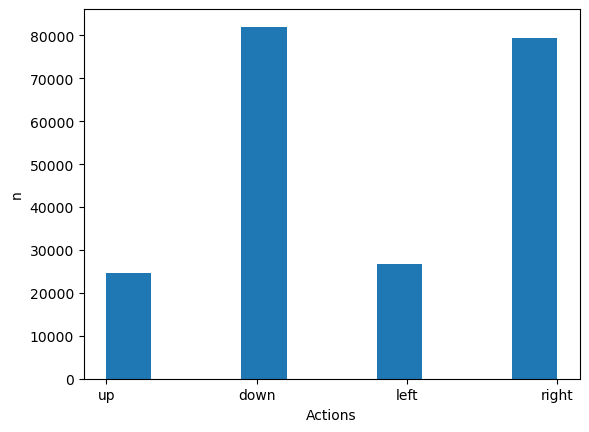

In [74]:
plot_action_histogram(callback)

In [ ]:
   
goal = (15, 15)
max_steps = 1000

n = 100
terminated_count = 0
truncated_count = 0
for i in tqdm(range(n)):
    start_x = np.random.choice(range(16))
    start_y = np.random.choice(range(16))
    start = (start_y, start_x)

    env = GridEnv(empty_grid, start, goal, max_steps)
    obs, info = env.reset()
    for step in range(env.max_steps):
        action, _ = model.predict(obs, deterministic=True)
        
        obs, reward, terminated, truncated, info = env.step(action)
        
        if terminated or truncated:
            if terminated:
                terminated_count += 1
            elif truncated:
                truncated_count += 1
            break

print('terminated: ', terminated_count/n * 100, '%')

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

cmap = ListedColormap([
    "white",   # 0
    "black",   # 1
    "red",     # 2
    "yellow"   # 3
])


start_x = np.random.choice(range(16))
start_y = np.random.choice(range(16))
start = (start_y, start_x)

goal = (15, 15)
max_steps = 1000

env = GridEnv(empty_grid, start, goal, max_steps)

obs, info = env.reset()  # obs shape: (1, obs_dim)

images = []
plt.imshow(np.sum(obs, axis=0), cmap=cmap)
plt.show()
images.append(obs[0])

for i in range(50):
    action, _ = model.predict(obs, deterministic=True)
    
        
    obs, reward, terminated, truncated, info = env.step(action)
    images.append(obs[0])
    plt.imshow(obs[0], cmap=cmap)
    plt.show()
    if terminated:
        break

## random start, random goal, fixed empty env

In [79]:
# random start point
from stable_baselines3.common.vec_env import DummyVecEnv
env_size = (16, 16)
empty_grid = np.zeros(env_size)
goal = (15,15)
max_steps = 32
lr = 2.5e-4
total_timesteps=500000
ent_coef = 0.01
def get_random_point(env_size):
    point_x = np.random.choice(range(env_size[0]))
    point_y = np.random.choice(range(env_size[0]))
    point = (point_y, point_x)
    return point
def make_env():
    def _init():
        while True:
            start = get_random_point(env_size)
            goal = get_random_point(env_size)
            
            if start != goal:
                break
        return GridEnv(empty_grid, start, goal, max_steps)
    return _init


env = DummyVecEnv([make_env() for _ in range(16)])

batch_size = 64
callback = ActionStoreCallback()
model = PPO("MlpPolicy", env, tensorboard_log="./rl_agent_static_tensorboard/", learning_rate=lr, batch_size=batch_size, n_steps=1024, device='cpu', ent_coef= ent_coef).learn(total_timesteps=total_timesteps, callback=callback, progress_bar=True)


Output()

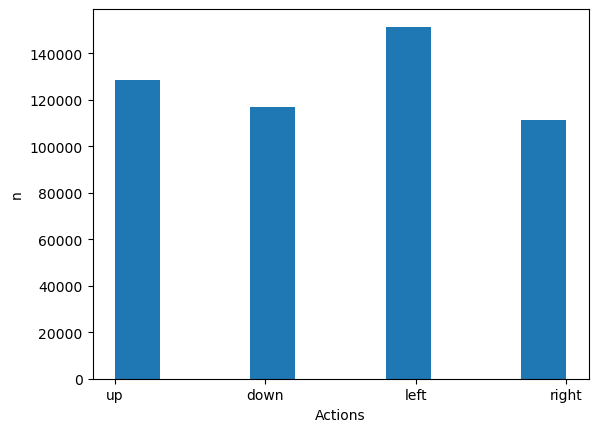

In [80]:
plot_action_histogram(callback)

In [68]:
goal = (15, 15)
max_steps = 1000

n = 100
terminated_count = 0
truncated_count = 0
for i in tqdm(range(n)):
    start_x = np.random.choice(range(16))
    start_y = np.random.choice(range(16))
    start = (start_y, start_x)

    env = GridEnv(empty_grid, start, goal, max_steps)
    obs, info = env.reset()
    for step in range(env.max_steps):
        action, _ = model.predict(obs, deterministic=True)
        
        obs, reward, terminated, truncated, info = env.step(action)
        
        if terminated or truncated:
            if terminated:
                terminated_count += 1
            elif truncated:
                truncated_count += 1
            break

print('terminated: ', terminated_count/n * 100, '%')

100%|██████████| 100/100 [00:25<00:00,  3.89it/s]

terminated:  0.0 %


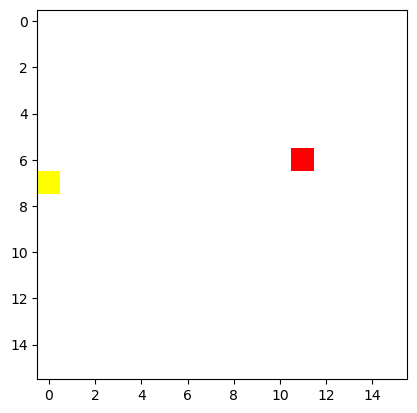

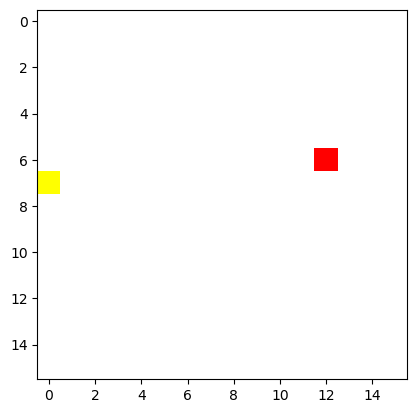

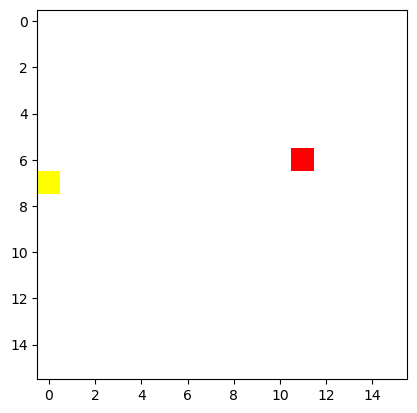

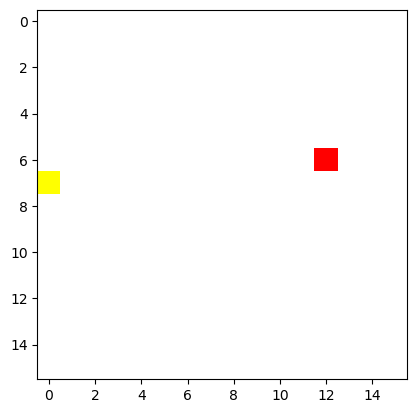

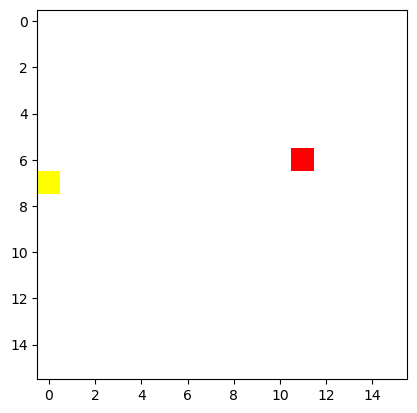

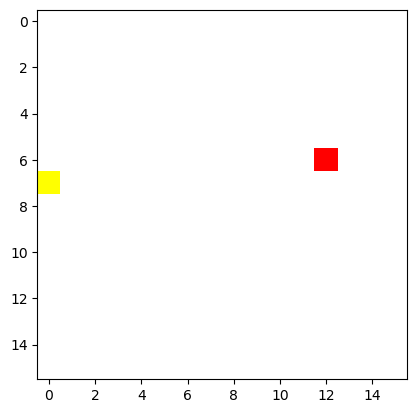

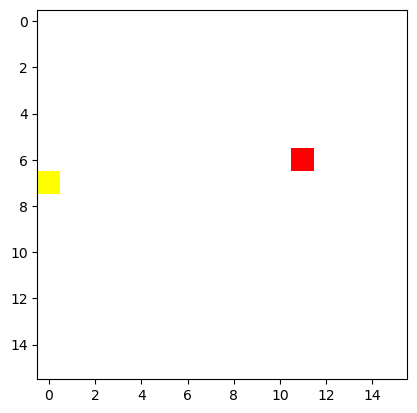

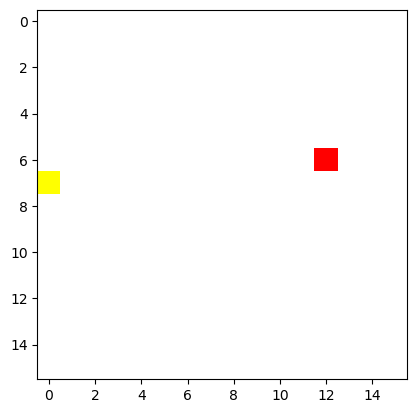

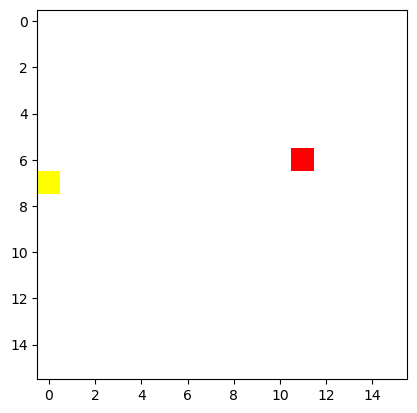

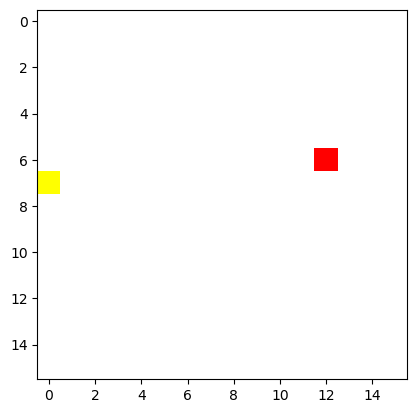

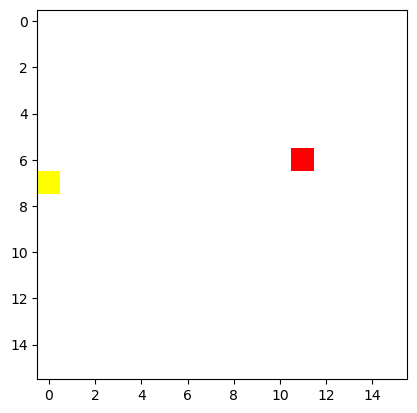

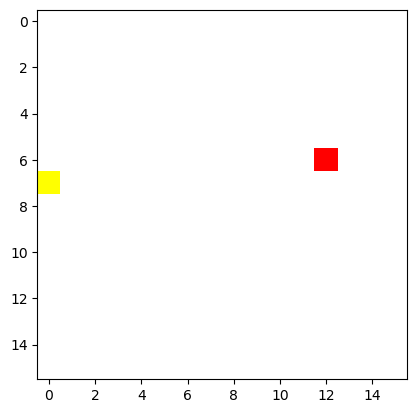

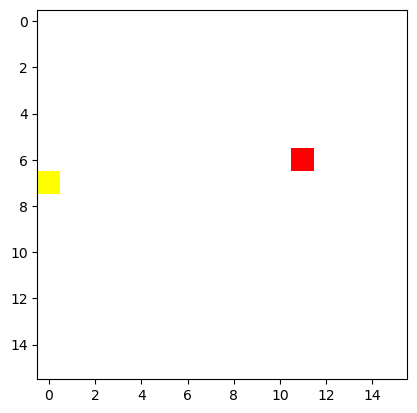

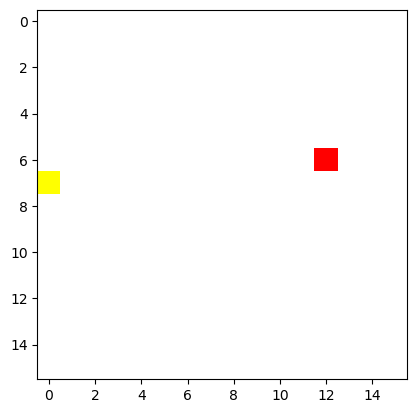

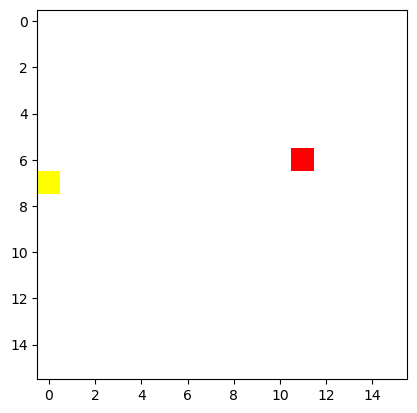

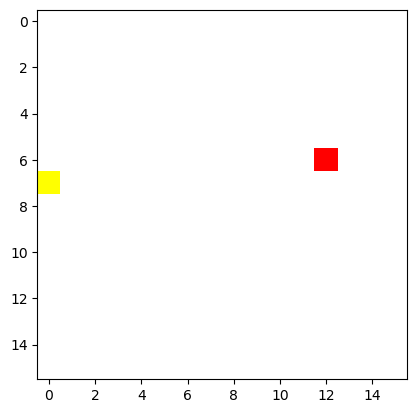

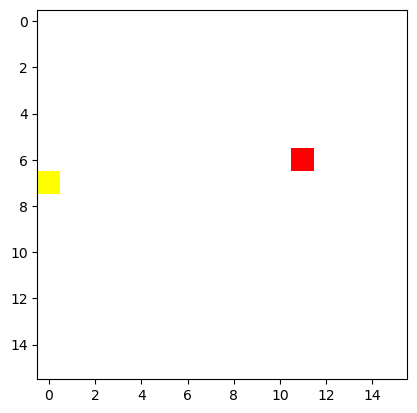

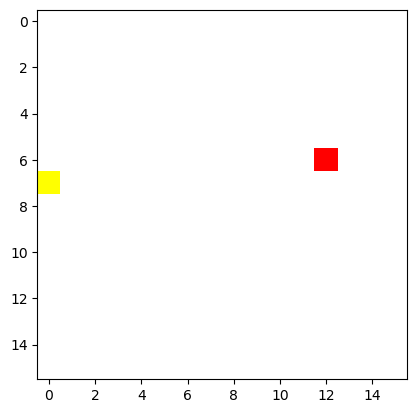

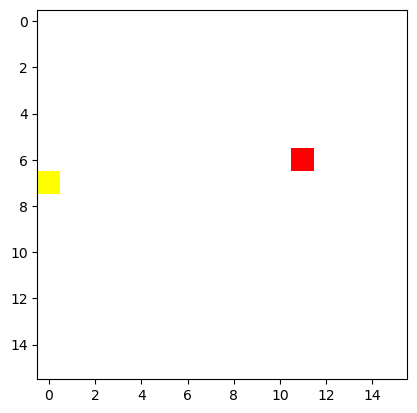

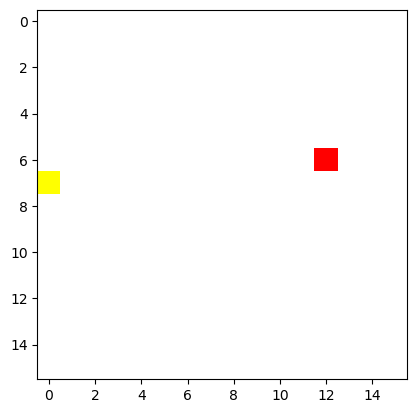

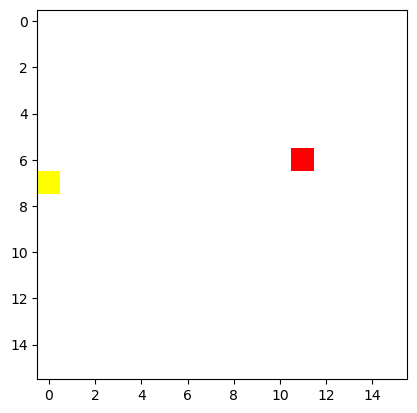

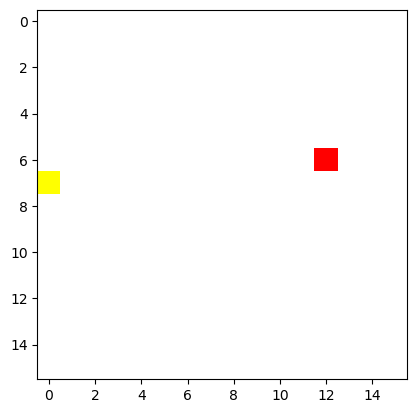

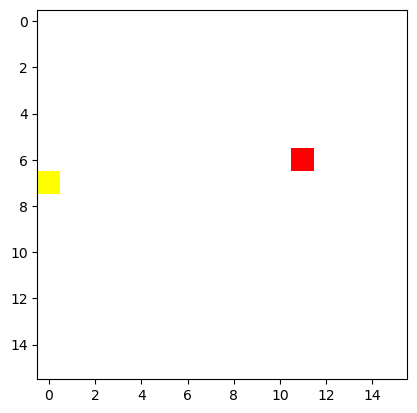

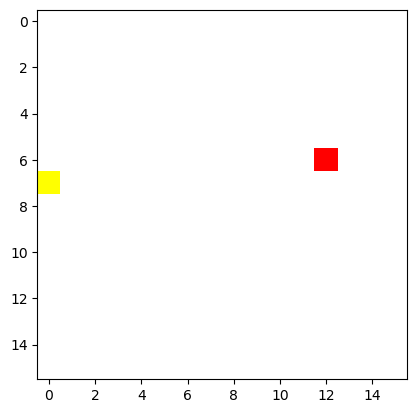

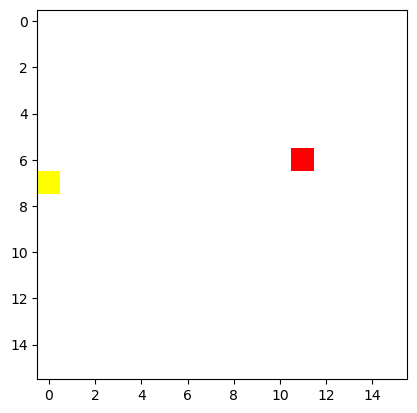

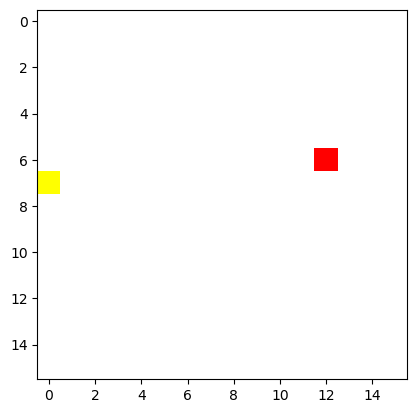

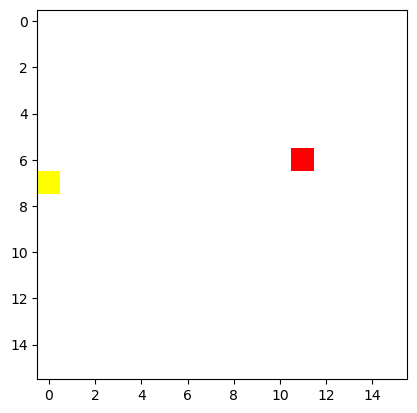

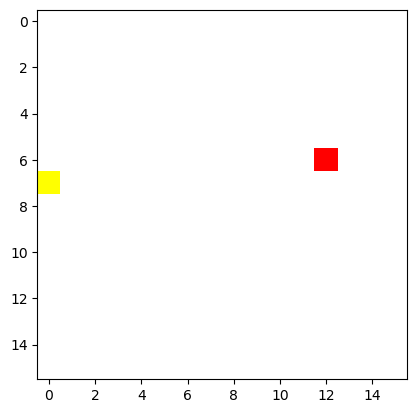

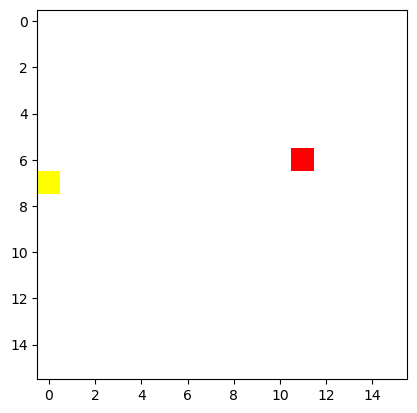

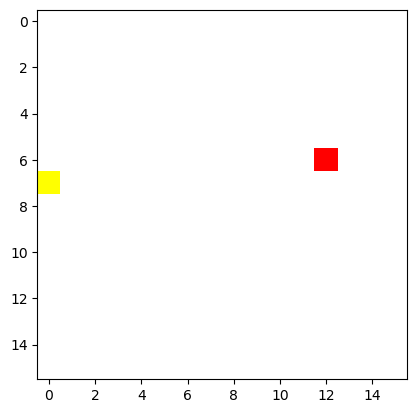

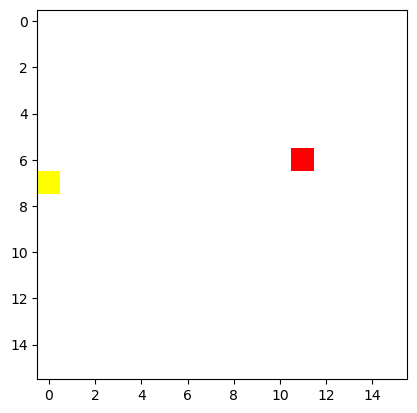

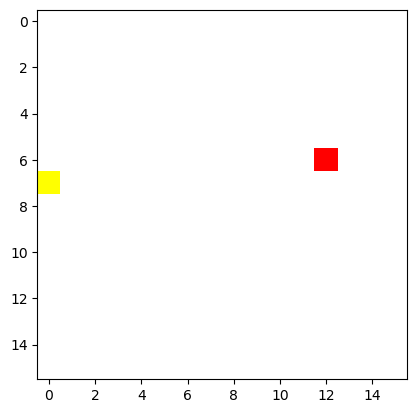

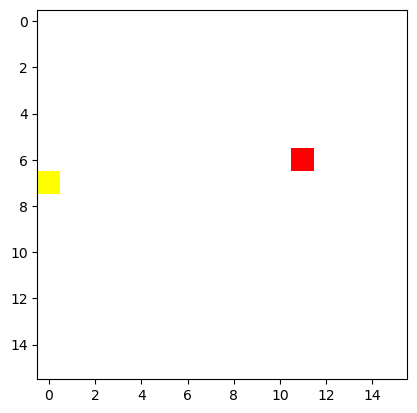

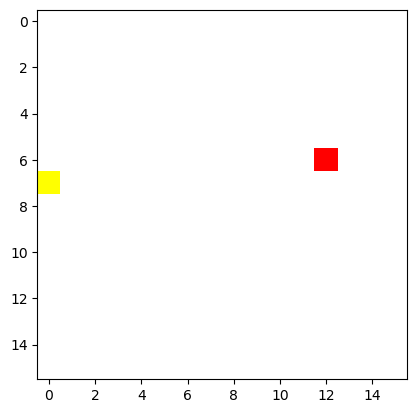

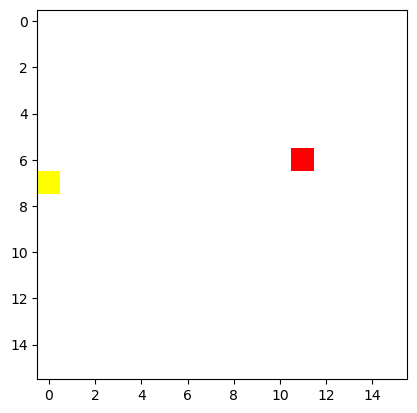

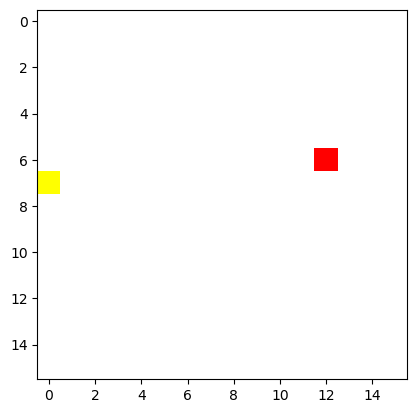

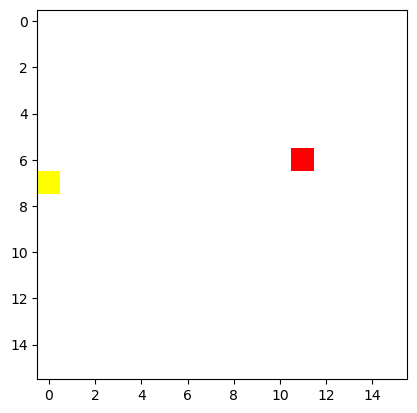

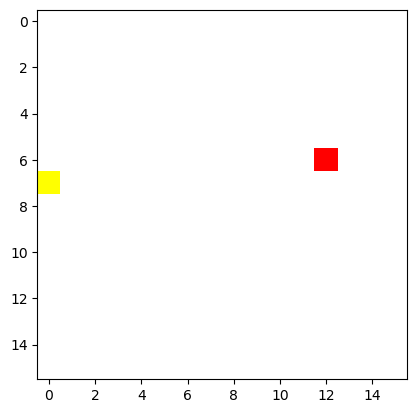

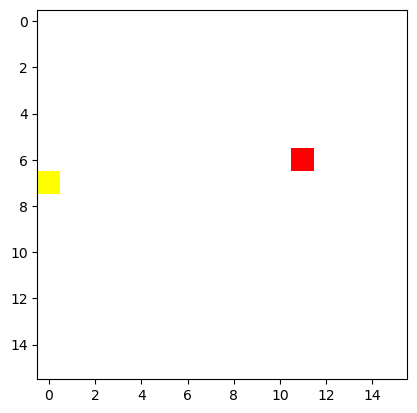

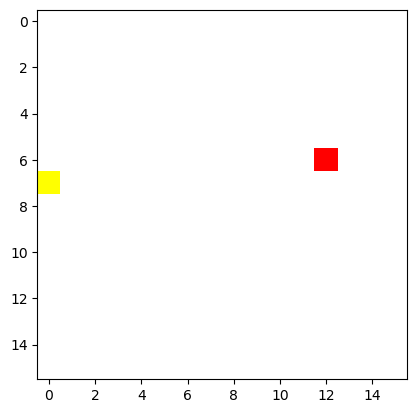

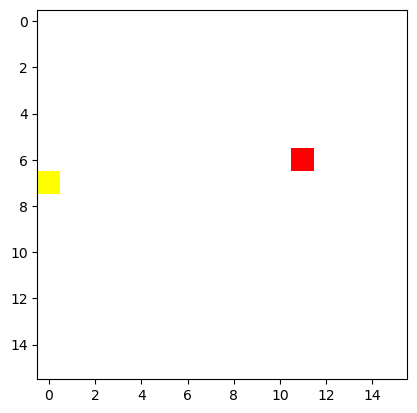

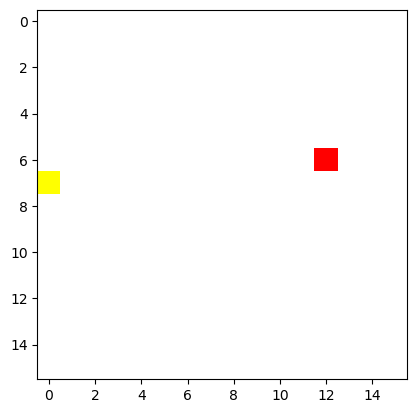

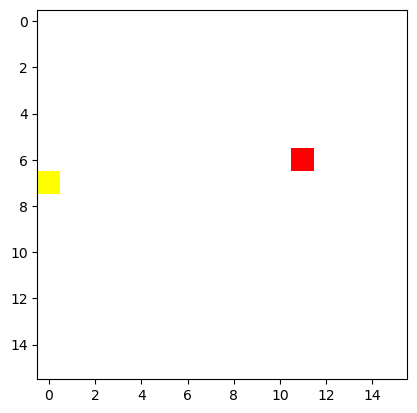

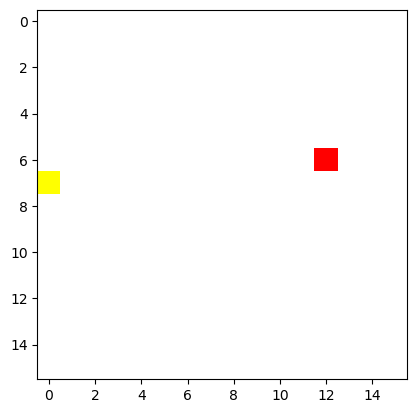

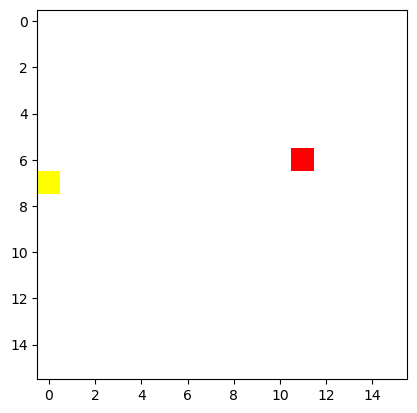

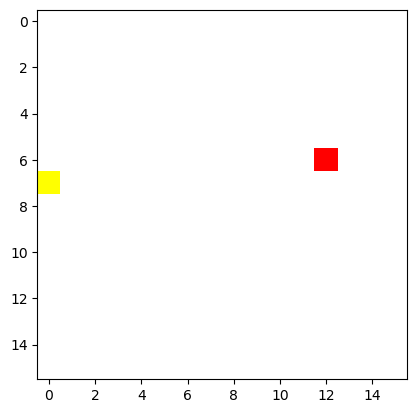

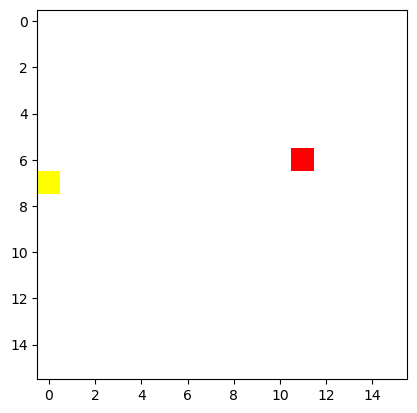

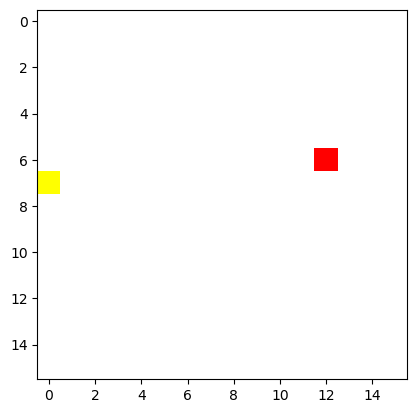

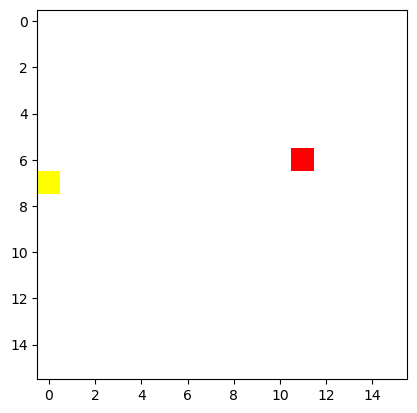

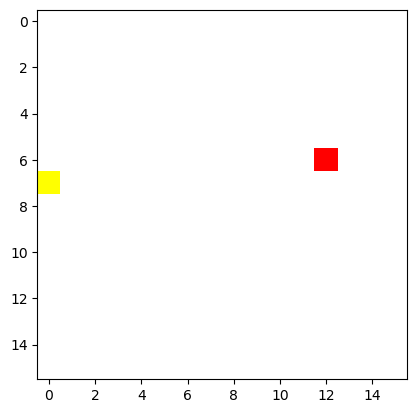

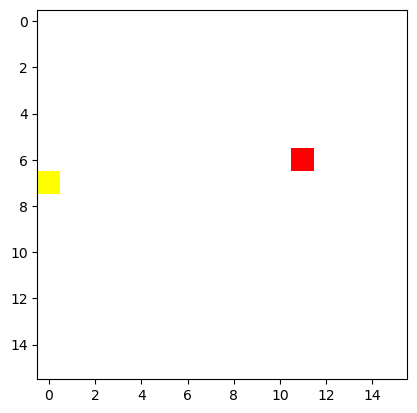

In [83]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

cmap = ListedColormap([
    "white",   # 0
    "black",   # 1
    "red",     # 2
    "yellow"   # 3
])


start = get_random_point(env_size)
goal = get_random_point(env_size)
max_steps = 32

env = GridEnv(empty_grid, start, goal, max_steps)

obs, info = env.reset()  # obs shape: (1, obs_dim)

images = []
plt.imshow(np.sum(obs, axis=0), cmap=cmap)
plt.show()
images.append(obs[0])

for i in range(50):
    action, _ = model.predict(obs, deterministic=True)
    
        
    obs, reward, terminated, truncated, info = env.step(action)
    images.append(obs[0])
    plt.imshow(obs[0], cmap=cmap)
    plt.show()
    if terminated:
        break

## fixed start, end, env

In [4]:
empty_grid = np.zeros((16, 16))
start = (0,0)
goal = (15,15)
max_steps = 1000
lr = 2.5e-4
total_timesteps=100000
ent_coef = 0.01


env = GridEnv(grid, start, goal, max_steps)

# Define and Train the agent
batch_size = 512
callback = ActionStoreCallback()
model = PPO("MlpPolicy", env, tensorboard_log="./rl_agent_static_tensorboard/", learning_rate=lr, batch_size=batch_size, n_steps=1024, device='cpu', ent_coef= ent_coef).learn(total_timesteps=total_timesteps, callback=callback, progress_bar=True)

# model = PPO.load('ppo_gridworld.zip', env, tensorboard_log="./rl_agent_static_tensorboard/", learning_rate=lr, batch_size=batch_size, n_steps=1024, device='cpu', ent_coef= ent_coef)
# model.learn(total_timesteps=total_timesteps, callback=callback, progress_bar=True)

Output()

In [61]:
model.save("ppo_gridworld")

In [5]:
# start = (0,0)
# goal = (63,63)
# max_steps = 2000
# lr = 2.5e-4

# env = GridEnv(grid, start, goal, max_steps)

# model = PPO.load("ppo_gridworld", env=env, device='cpu')
# model.learn(total_timesteps=200_000, callback=callback, progress_bar=True)

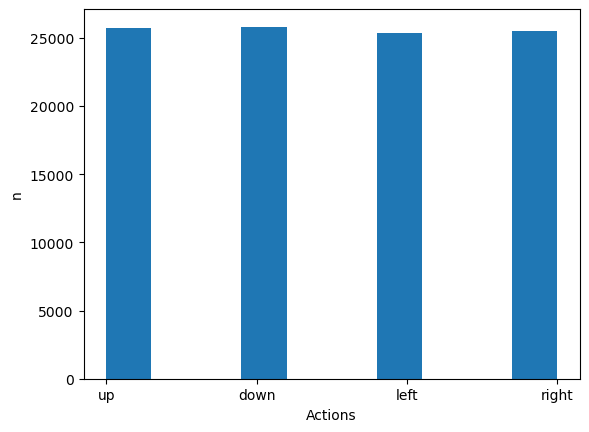

In [5]:
actions_array = np.array(callback.actions).flatten()
plt.hist(actions_array, label = 'Action Histogram')
plt.xlabel('Actions')
plt.ylabel('n')
plt.xticks([0,1,2,3], ['up', 'down', 'left', 'right'])
plt.show()

In [14]:
env.reset()[2]

array([[[0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3]]], dtype=uint8)

In [ ]:
n = 100
terminated_count = 0
truncated_count = 0
for i in tqdm(range(n)):
    obs, info = env.reset()
    for step in range(env.max_steps):
        action, _ = model.predict(obs, deterministic=True)
        
        obs, reward, terminated, truncated, info = env.step(action)
        
        if terminated or truncated:
            if terminated:
                terminated_count += 1
            elif truncated:
                truncated_count += 1
            break

print('terminated: ', terminated_count/n * 100, '%')

  0%|          | 0/100 [00:00<?, ?it/s]


AttributeError: 'DummyVecEnv' object has no attribute 'max_steps'

In [7]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

cmap = ListedColormap([
    "white",   # 0
    "black",   # 1
    "red",     # 2
    "yellow"   # 3
])

obs, info = env.reset()  # obs shape: (1, obs_dim)

images = []
plt.imshow(np.sum(obs, axis=0), cmap=cmap)
plt.show()
images.append(obs[0])

for i in range(50):
    action, _ = model.predict(obs, deterministic=True)
    
        
    obs, reward, terminated, truncated, info = env.step(action)
    images.append(obs[0])
    plt.imshow(obs[0], cmap=cmap)
    plt.show()
    if terminated:
        break

ValueError: too many values to unpack (expected 2)

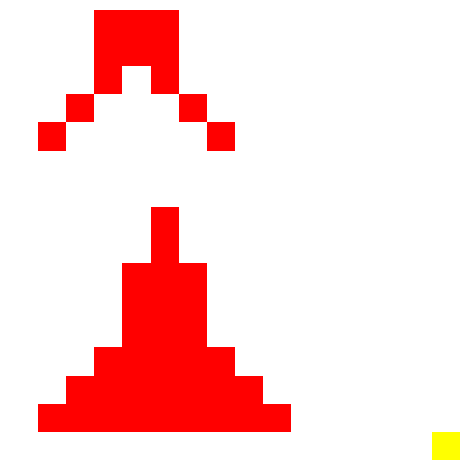

In [7]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
frames = []
for image in images:
    plt.imshow(image, cmap=cmap)
    plt.axis('off')

    plt.tight_layout()
    plt.savefig("temp.png", bbox_inches='tight', pad_inches=0)
    frames.append(Image.open("temp.png"))

# save as GIF
frames[0].save(
    "agent_animation.gif",
    save_all=True,
    append_images=frames[1:],
    duration=100,   # ms per frame
    loop=0
)

# 32x32

1.0


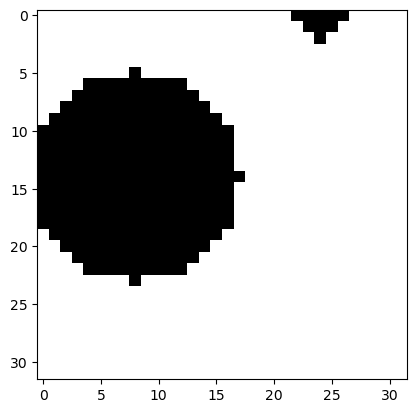

In [15]:
loaded = np.load('../environment_generation/environments/environments_32_2_10_1.npy')
loaded.shape

grid = loaded[0]
print(grid.max())
plt.imshow(grid, cmap='binary')

In [123]:
empty_grid = np.zeros((32, 32))
start = (0,0)
goal = (15,15)
max_steps = 4096
lr = 2.5e-4
total_timesteps=500000
ent_coef = 0.05
gamma = 0.99


env = GridEnv(grid, start, goal, max_steps)

# Define and Train the agent
batch_size = 512
callback = ActionStoreCallback()
model = PPO("MlpPolicy", env, tensorboard_log="./rl_agent_static_tensorboard/", learning_rate=lr, batch_size=batch_size, n_steps= 4096, device='cpu', ent_coef= ent_coef, gamma = gamma).learn(total_timesteps=total_timesteps, callback=callback, progress_bar=True)

# model = PPO.load('ppo_gridworld.zip', env, tensorboard_log="./rl_agent_static_tensorboard/", learning_rate=lr, batch_size=batch_size, n_steps=1024, device='cpu', ent_coef= ent_coef)
# model.learn(total_timesteps=total_timesteps, callback=callback, progress_bar=True)

Output()

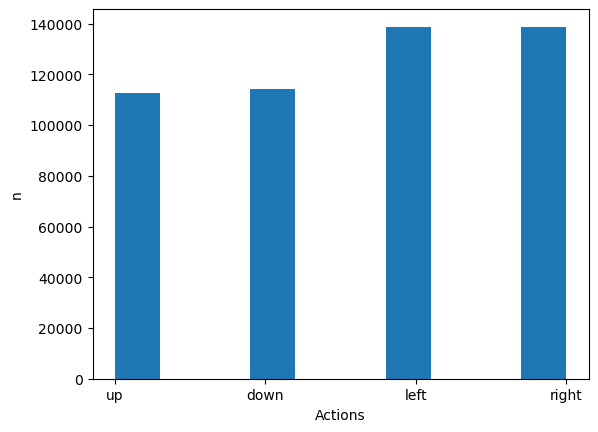

In [124]:
actions_array = np.array(callback.actions).flatten()
plt.hist(actions_array, label = 'Action Histogram')
plt.xlabel('Actions')
plt.ylabel('n')
plt.xticks([0,1,2,3], ['up', 'down', 'left', 'right'])
plt.show()

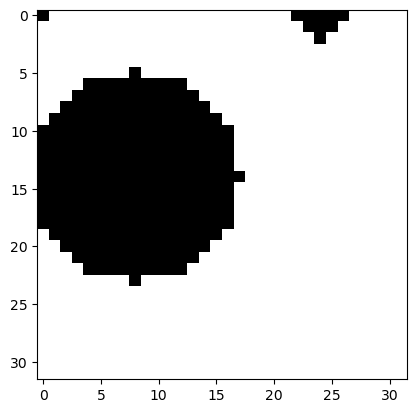

2


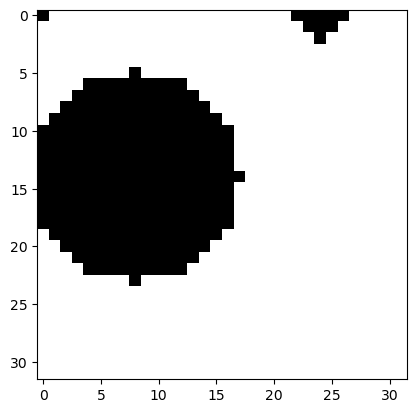

2


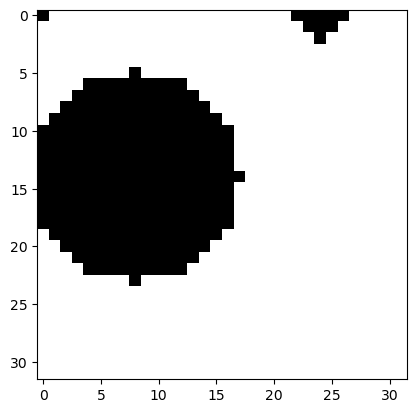

2


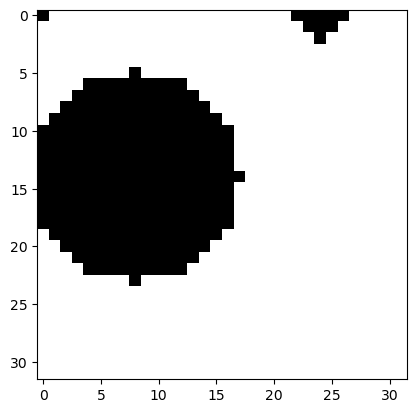

2


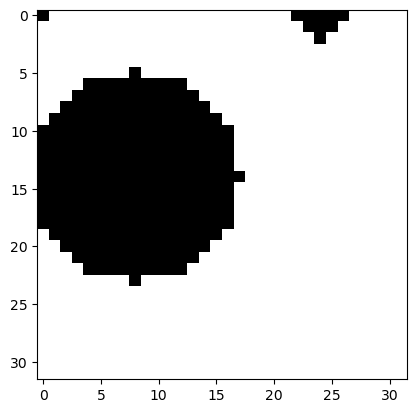

2


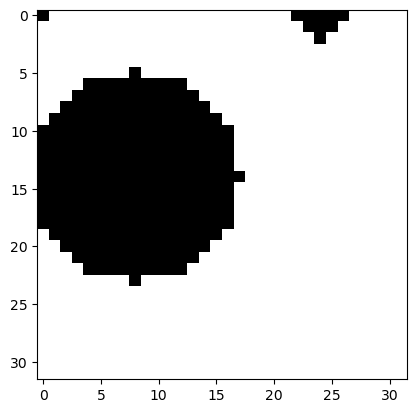

2


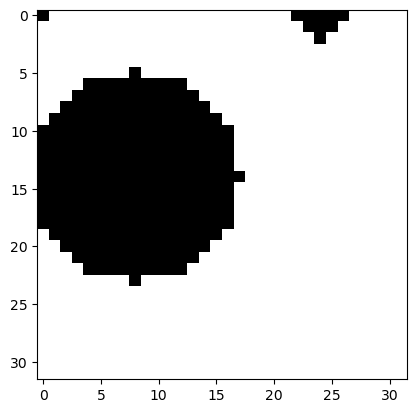

2


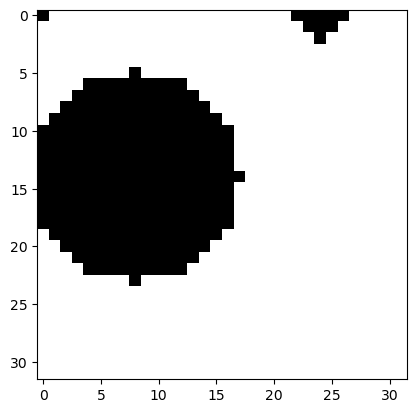

2


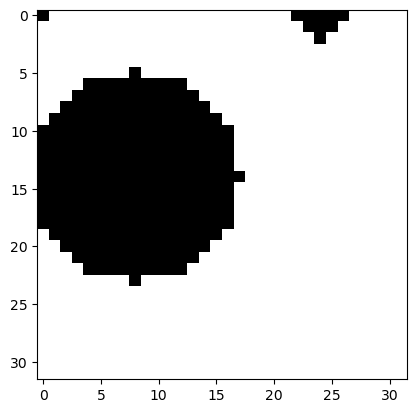

2


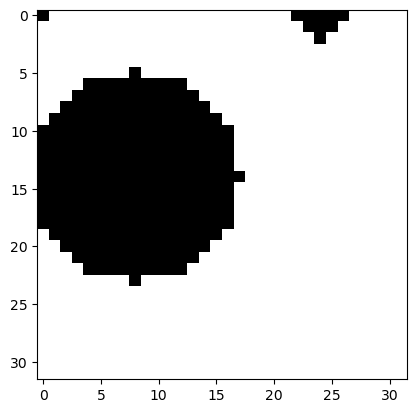

2


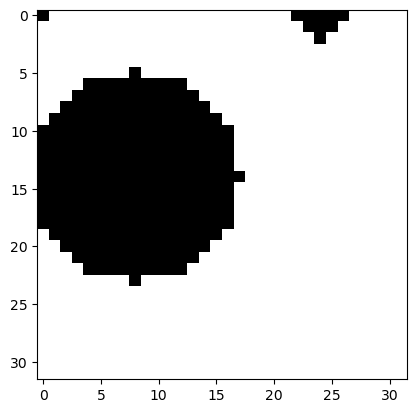

2


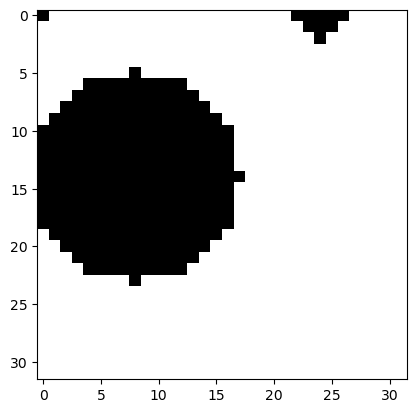

2


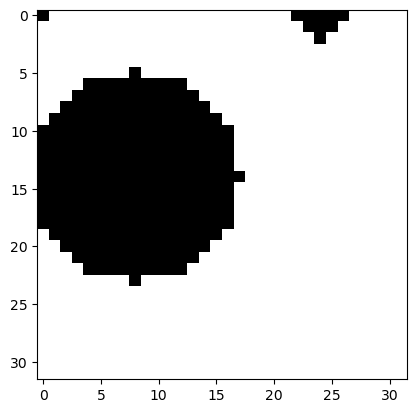

2


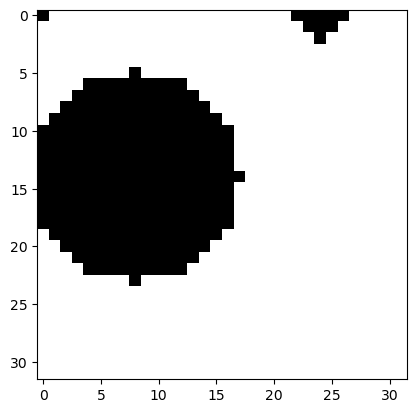

2


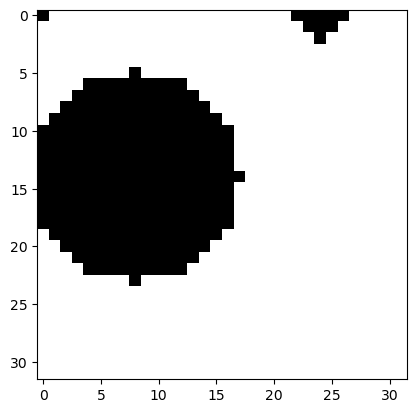

2


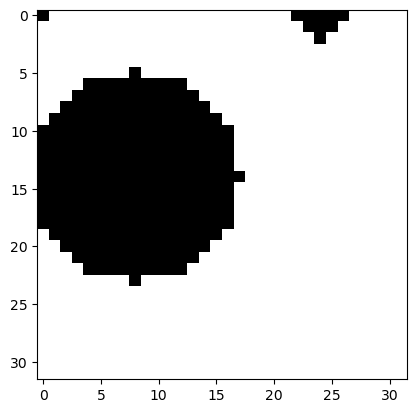

2


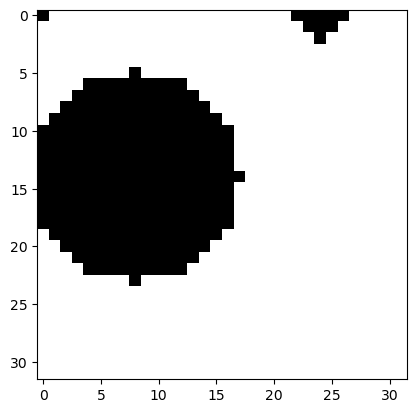

2


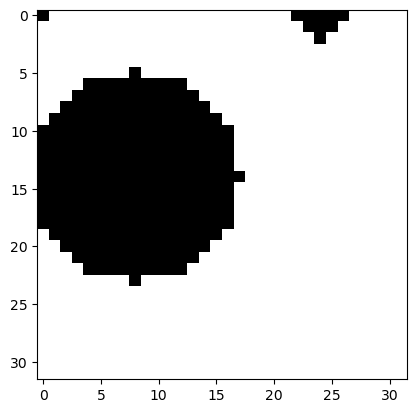

2


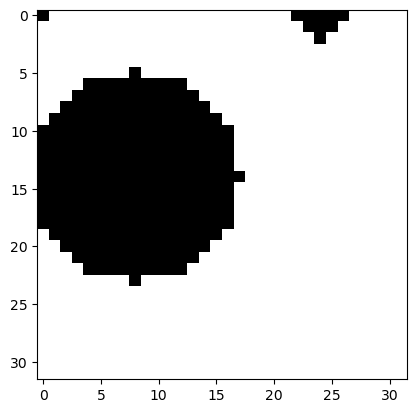

2


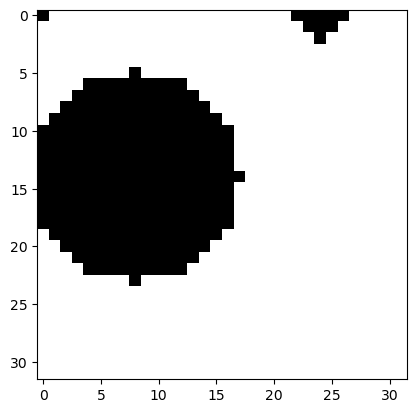

2


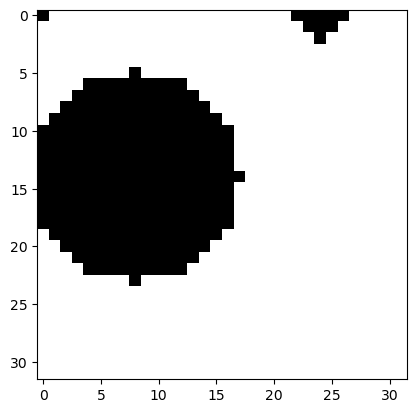

2


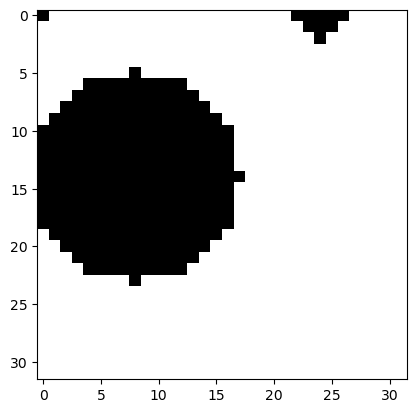

2


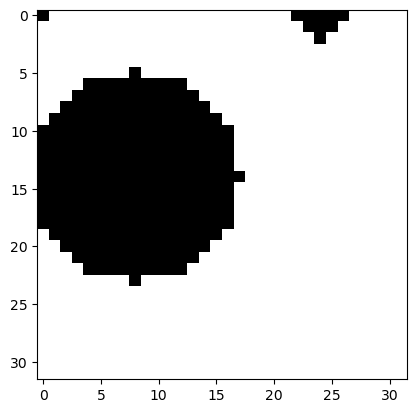

2


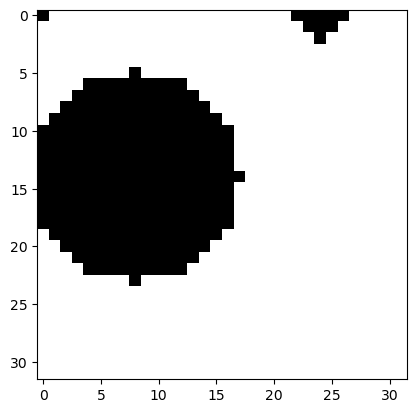

2


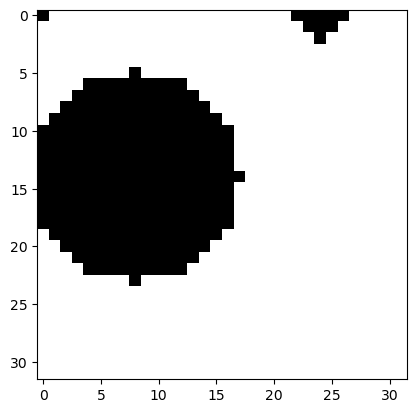

2


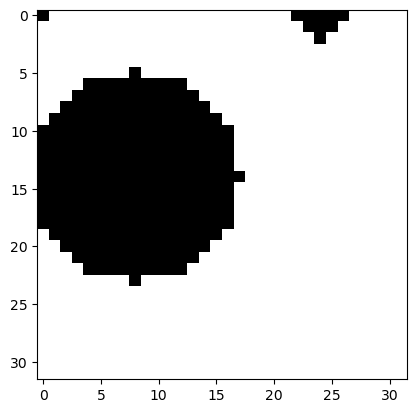

2


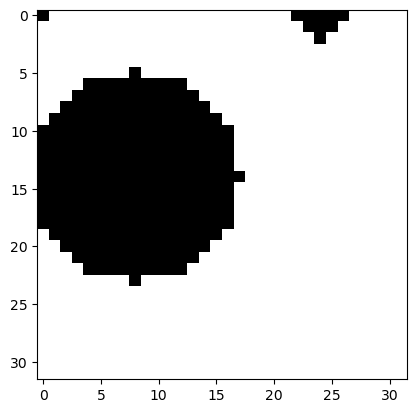

2


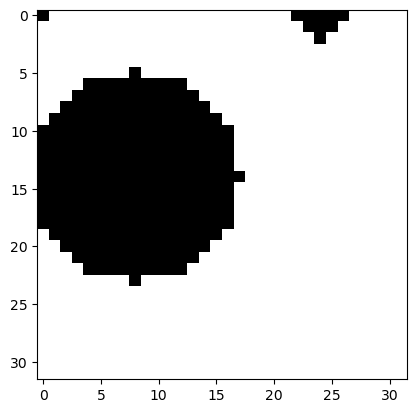

2


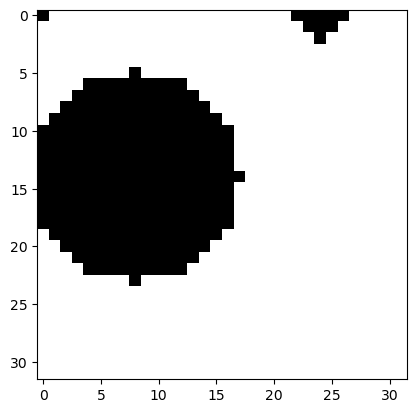

2


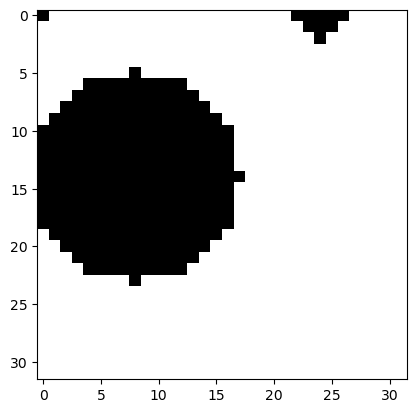

2


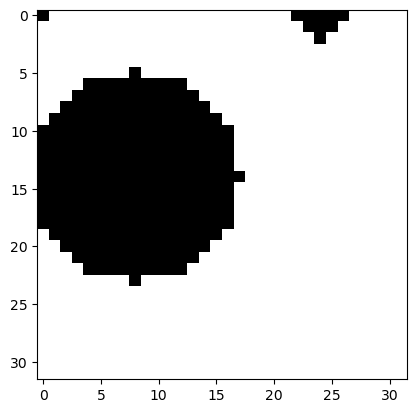

2


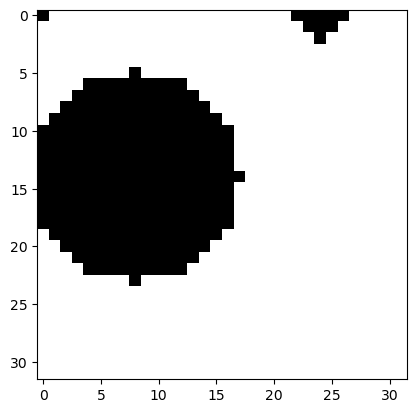

2


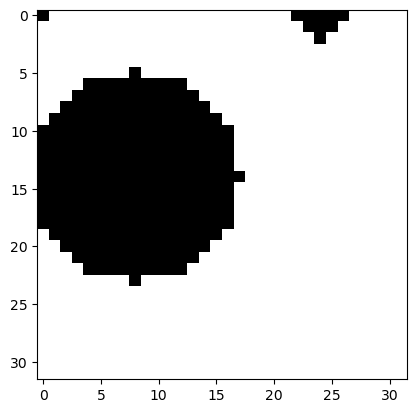

2


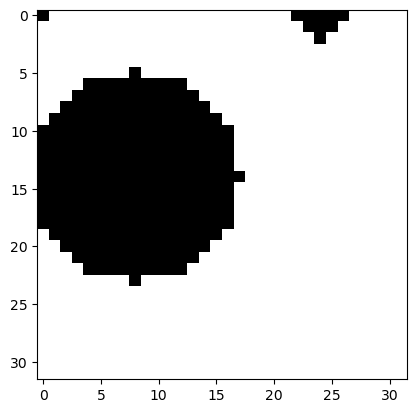

2


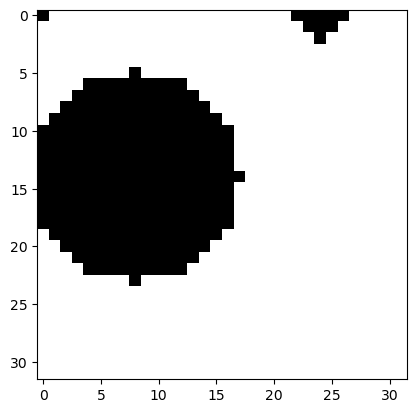

2


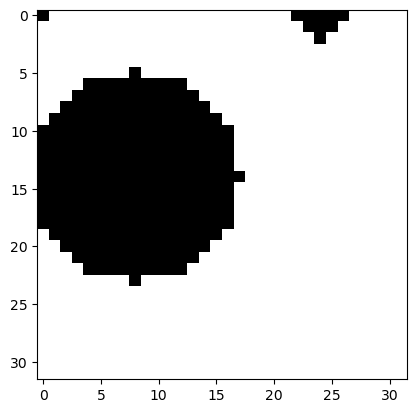

2


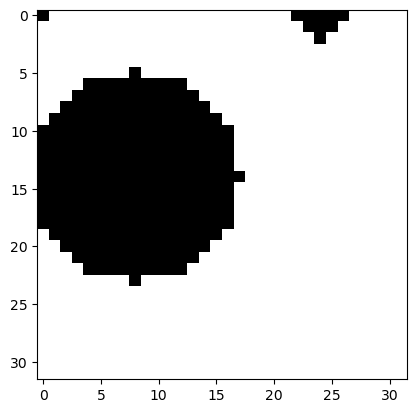

2


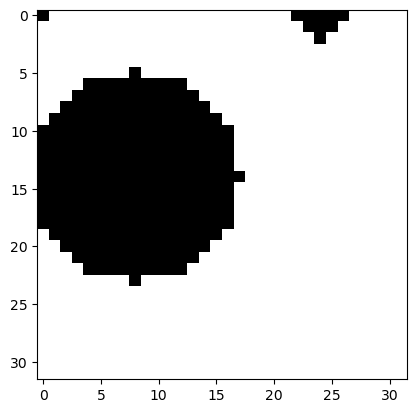

2


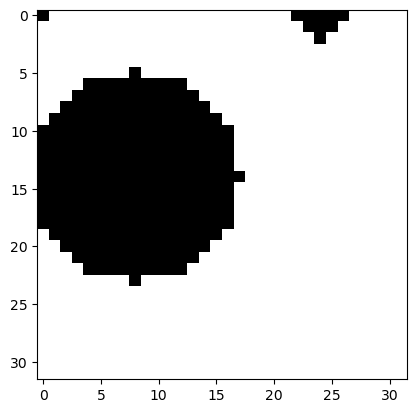

2


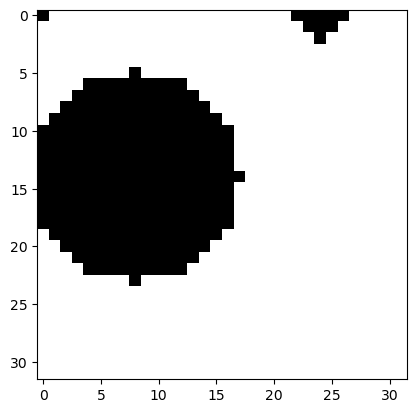

2


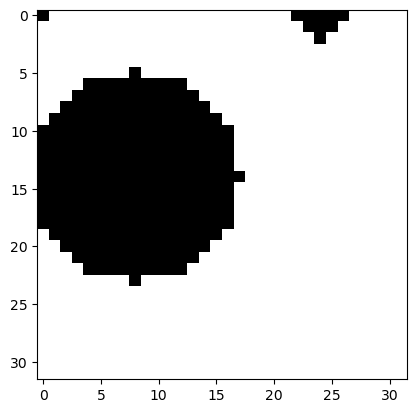

2


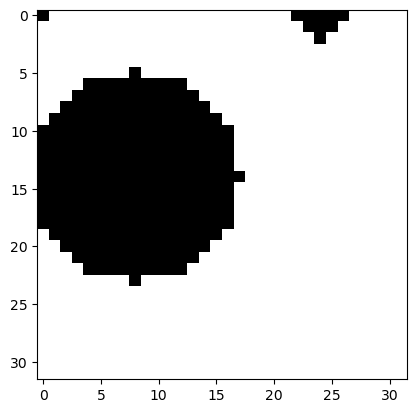

2


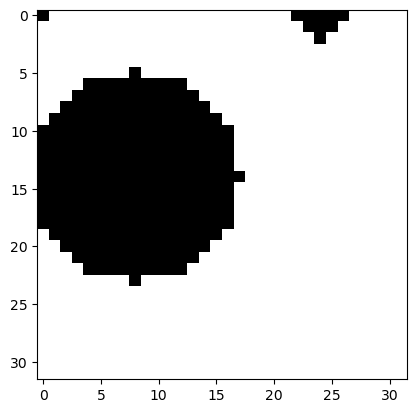

2


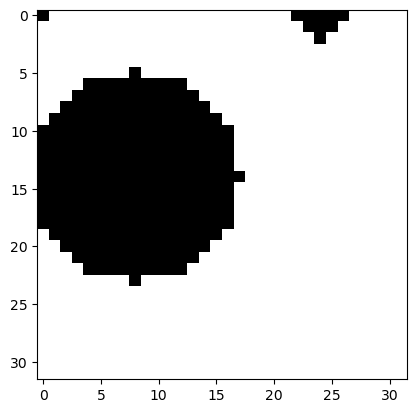

2


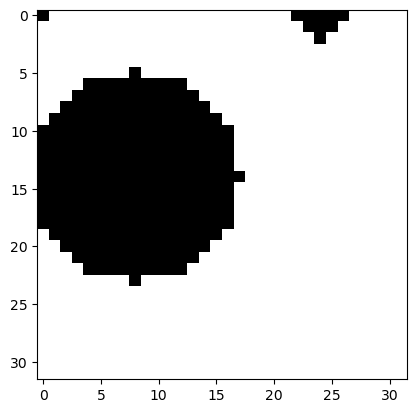

2


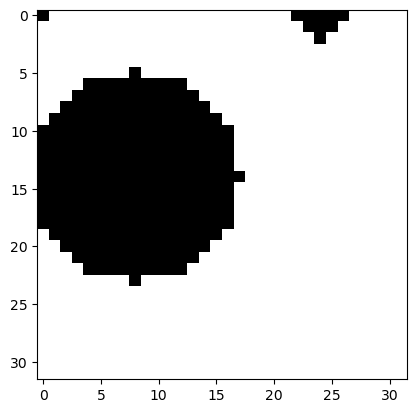

2


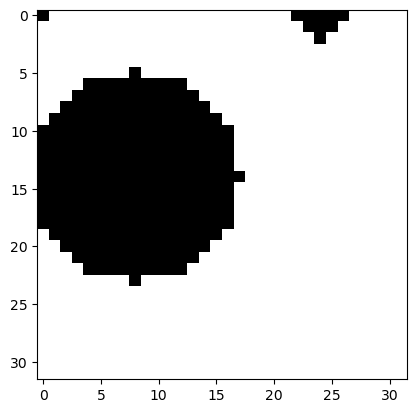

2


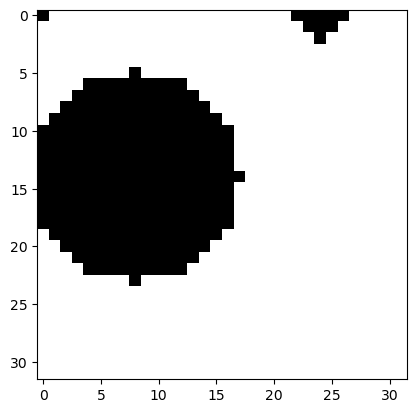

2


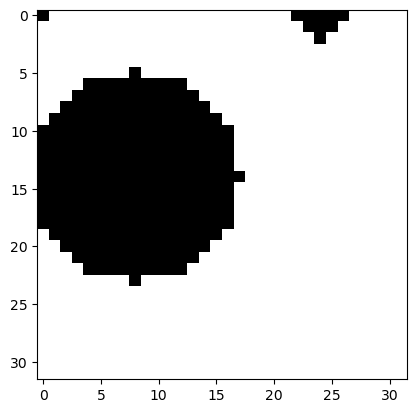

2


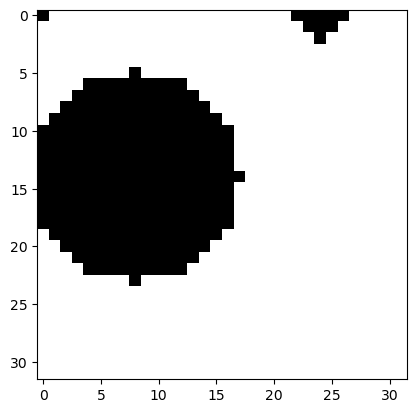

2


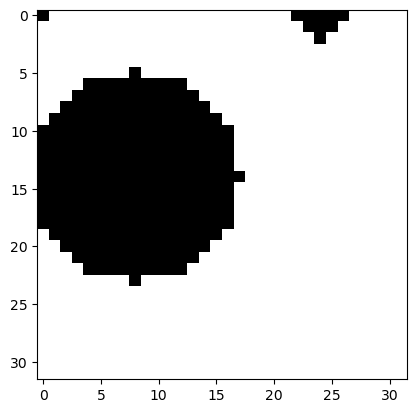

In [125]:
obs, info = env.reset()  # obs shape: (1, obs_dim)
plt.imshow(np.sum(obs, axis=0), cmap='binary')
plt.show()

for i in range(50):
    action, _ = model.predict(obs, deterministic=True)
    print(action)
        
    obs, reward, terminated, truncated, info = env.step(action)
    
    plt.imshow(np.sum(obs, axis=0), cmap='binary')
    plt.show()
    if terminated:
        break

# 64x64 MLP Policy

## random start, fixed environment, fixed goal

In [17]:
# random start point
from stable_baselines3.common.vec_env import DummyVecEnv
env_size = (64,64)
empty_grid = np.zeros(env_size)
goal = (63,63)
max_steps = 4000
lr = 2.5e-4
total_timesteps=200000
ent_coef = 0.01


def make_env():
    def _init():
        while True:
            start_x = np.random.choice(range(env_size[0]))
            start_y = np.random.choice(range(env_size[0]))
            start = (start_y, start_x)
            if start != goal:
                break
        return GridEnvMLP(empty_grid, start, goal, max_steps)
    return _init


env = DummyVecEnv([make_env() for _ in range(32)])

batch_size = 64
callback = ActionStoreCallback()
model = PPO("MlpPolicy", env, tensorboard_log="./rl_agent_static_tensorboard/", learning_rate=lr, batch_size=batch_size, n_steps=4096, device='cpu', ent_coef= ent_coef).learn(total_timesteps=total_timesteps, callback=callback, progress_bar=True)

Output()

KeyboardInterrupt: 

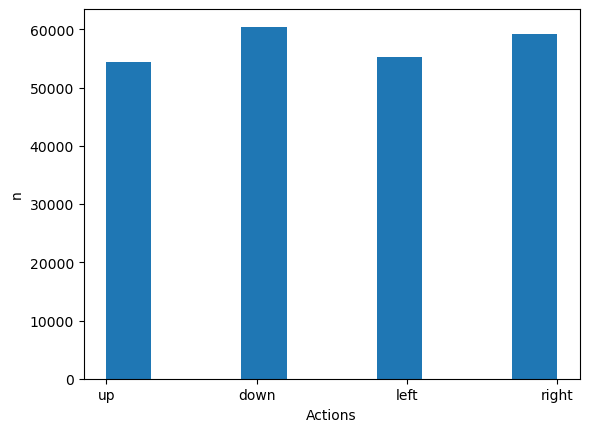

In [41]:
actions_array = np.array(callback.actions).flatten()
plt.hist(actions_array, label = 'Action Histogram')
plt.xlabel('Actions')
plt.ylabel('n')
plt.xticks([0,1,2,3], ['up', 'down', 'left', 'right'])
plt.show()

In [ ]:

max_steps = 1000

n = 100
terminated_count = 0
truncated_count = 0
for i in tqdm(range(n)):
    start_x = np.random.choice(range(env_size[0]))
    start_y = np.random.choice(range(env_size[0]))
    start = (start_y, start_x)

    env = GridEnvMLP(empty_grid, start, goal, max_steps)
    obs, info = env.reset()
    for step in range(env.max_steps):
        action, _ = model.predict(obs, deterministic=True)
        
        obs, reward, terminated, truncated, info = env.step(action)
        
        if terminated or truncated:
            if terminated:
                terminated_count += 1
            elif truncated:
                truncated_count += 1
            break

print('terminated: ', terminated_count/n * 100, '%')

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

cmap = ListedColormap([
    "white",   # 0
    "black",   # 1
    "red",     # 2
    "green"   # 3
])


start_x = np.random.choice(range(env_size[0]))
start_y = np.random.choice(range(env_size[0]))
start = (start_y, start_x)

max_steps = 1000
goal = (63, 63)

env = GridEnvMLP(empty_grid, start, goal, max_steps)

obs, info = env.reset()  # obs shape: (1, obs_dim)

images = []
plt.imshow(np.sum(obs, axis=0), cmap=cmap)
plt.show()
images.append(obs[0])

for i in range(50):
    action, _ = model.predict(obs, deterministic=True)
    
        
    obs, reward, terminated, truncated, info = env.step(action)
    images.append(obs[0])
    plt.imshow(obs[0], cmap=cmap)
    plt.show()
    if terminated:
        break

# 64x64 CNN Policy with custom feature extraction

In [ ]:
def make_env(grids):
    def _init():
        while True: 
            start_x = np.random.choice(range(env_size[0]))
            start_y = np.random.choice(range(env_size[0]))
            start = (start_y, start_x)
            if start != goal: 
                break
        
        if isinstance(grids, list):
            grid = grids[np.random.choice(range(len(grids)))]
            env = GridEnvCNN(grid, start, goal, max_steps)
        else:
            env = GridEnvCNN(grids, start, goal, max_steps)
        return env
    return _init

In [ ]:
n_steps           = 2048
batch_size        = 256      
n_epochs          = 4        
learning_rate     = 3e-4     
ent_coef          = 0.001    
clip_range        = 0.2
gamma             = 0.995 
gae_lambda        = 0.95
max_grad_norm     = 0.5
normalize_advantage = True

num_envs          = 16
max_steps         = 256

total_timesteps   = 1500000

env_size = (64,64)
empty_grid = np.zeros(env_size)




env = DummyVecEnv([make_env(empty_grid) for _ in range(num_envs)])
env = VecMonitor(env, filename=None)

callback = ActionStoreCallback()
model = PPO(CustomCNNPolicy, env, tensorboard_log="./rl_agent_static_tensorboard/", learning_rate=learning_rate, batch_size=batch_size, n_steps=n_steps, device='cpu', ent_coef= ent_coef, n_epochs = n_epochs, gamma=gamma).learn(total_timesteps=total_timesteps, callback=callback, progress_bar=True)

 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1,507,328/1,500,000  [ 0:18:56 < 0:00:00 , 1,637 it/s ]

In [ ]:
model.save("ppo_custom_cnn_64x64_empty_random_start")

1.0


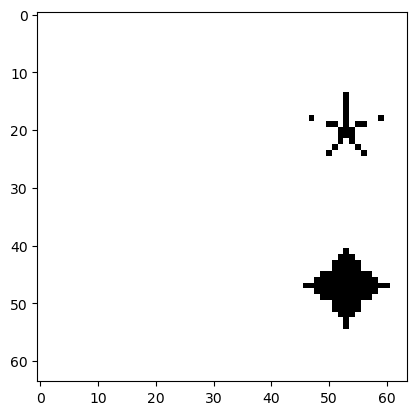

In [41]:
loaded = np.load('../environment_generation/environments/environments_64_2_10_1.npy')
loaded.shape

grid = loaded[6]
print(grid.max())
plt.imshow(grid, cmap='binary')

In [ ]:



env = DummyVecEnv([make_env(grid) for _ in range(16)])
env = VecMonitor(env, filename=None)

model = PPO.load("ppo_custom_cnn_64x64_empty_random_start", env=env, device='cpu')
model.learn(total_timesteps=200_000, callback=callback, progress_bar=True)

Output()

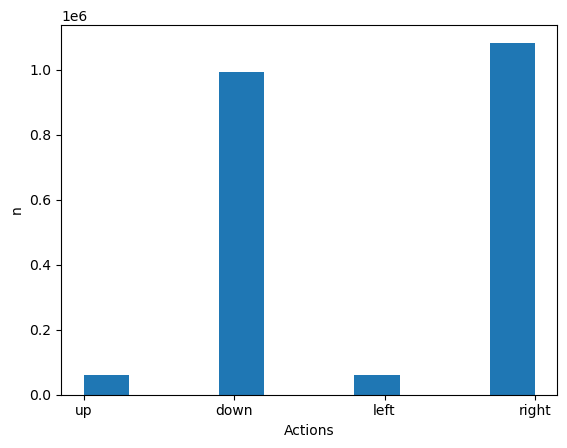

In [54]:
plot_action_histogram(callback)

In [132]:
model = PPO.load("ppo_custom_cnn_64x64_empty_random_start", env=env, device='cpu')

In [133]:

max_steps = 1000

n = 1000
terminated_count = 0
truncated_count = 0
for i in tqdm(range(n)):
    start_x = np.random.choice(range(env_size[0]))
    start_y = np.random.choice(range(env_size[0]))
    start = (start_y, start_x)

    env = GridEnvCNN(empty_grid, start, goal, max_steps)
    obs, info = env.reset()
    for step in range(env.max_steps):
        action, _ = model.predict(obs, deterministic=True)
        
        obs, reward, terminated, truncated, info = env.step(action)
        
        if terminated or truncated:
            if terminated:
                terminated_count += 1
            elif truncated:
                truncated_count += 1
            break

print('terminated: ', terminated_count/n * 100, '%')

100%|██████████| 1000/1000 [00:50<00:00, 19.65it/s]

terminated:  100.0 %


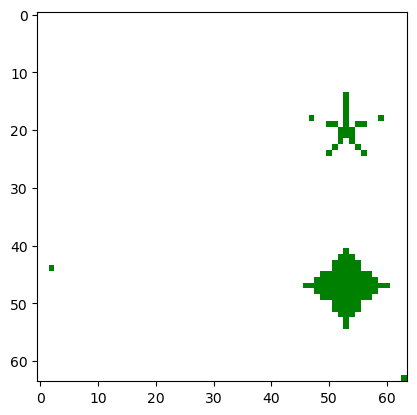

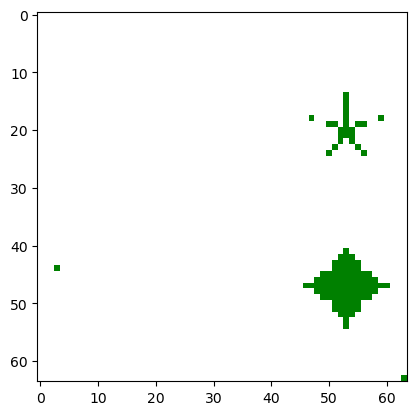

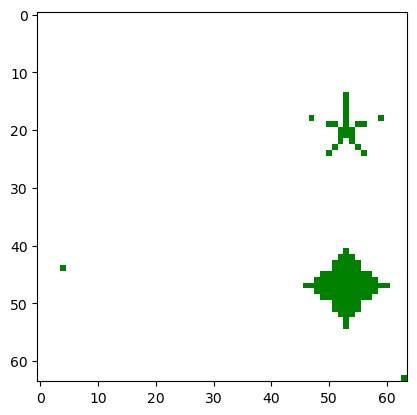

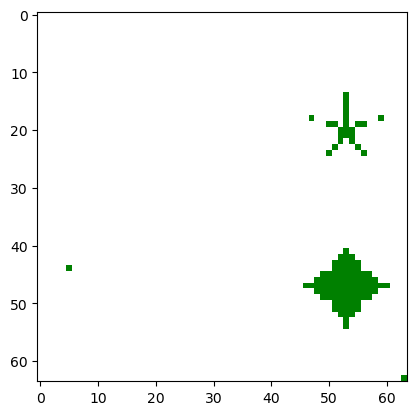

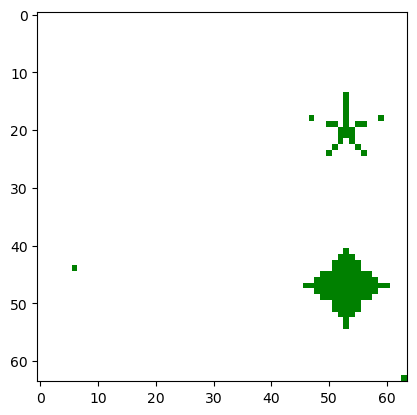

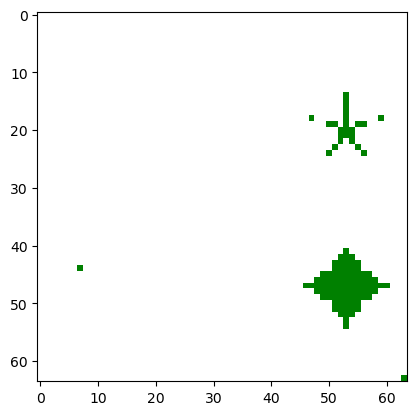

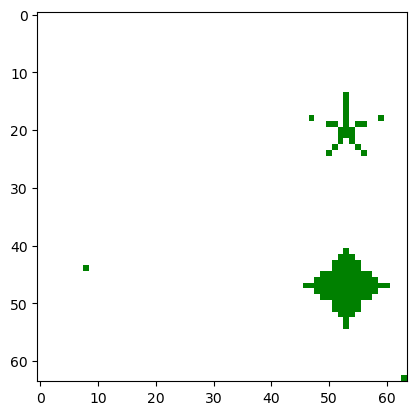

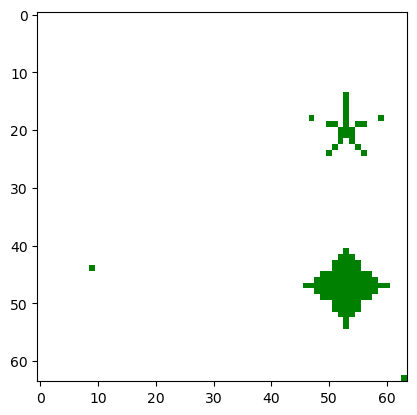

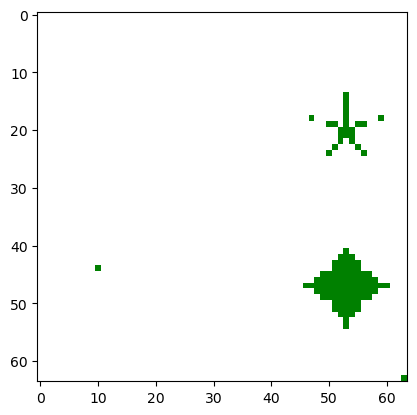

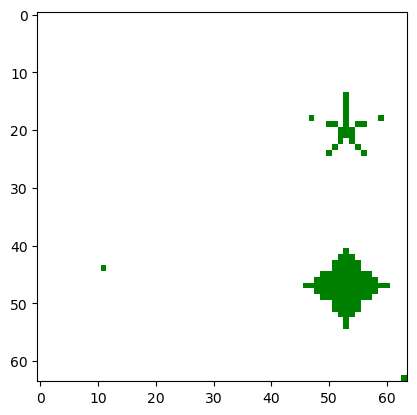

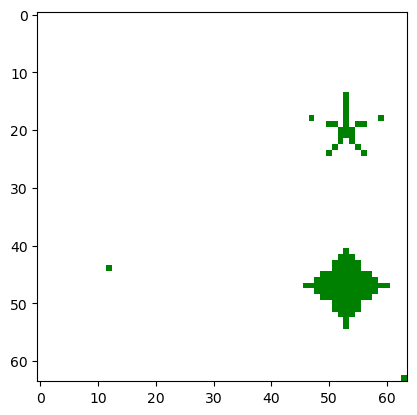

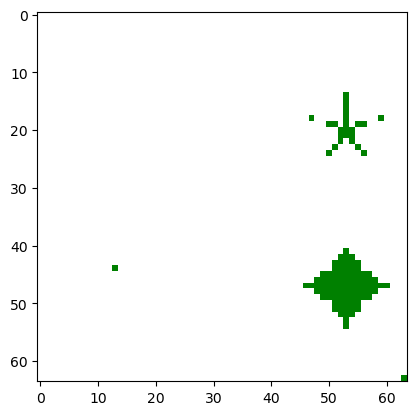

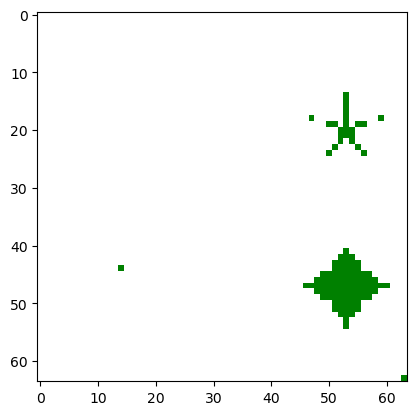

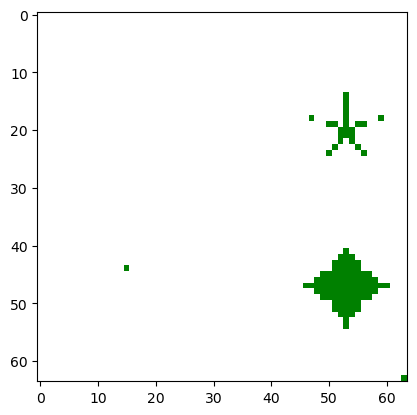

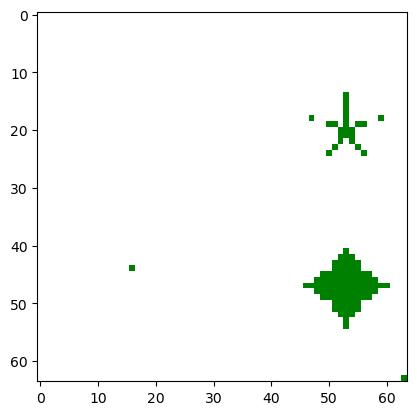

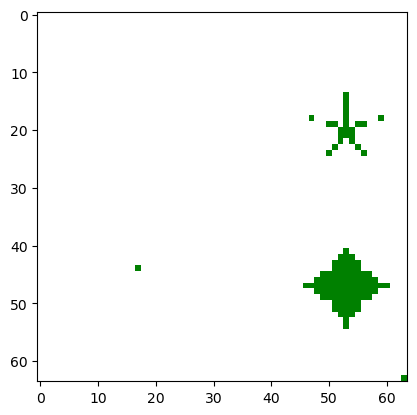

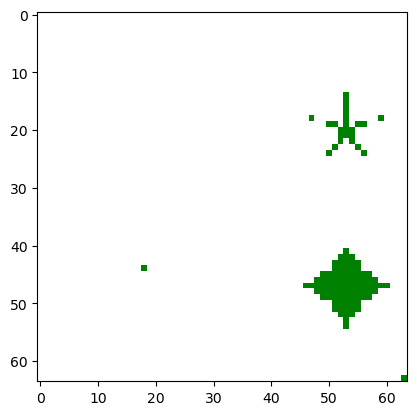

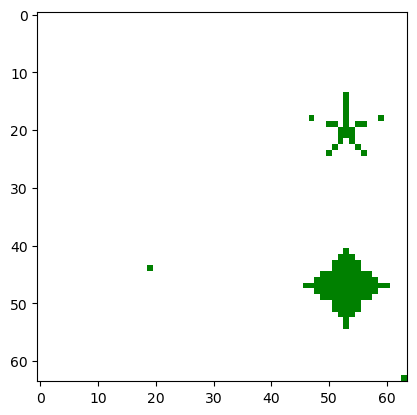

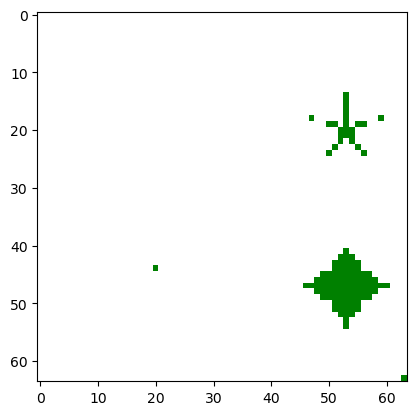

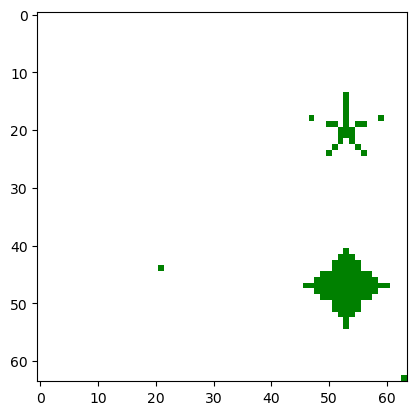

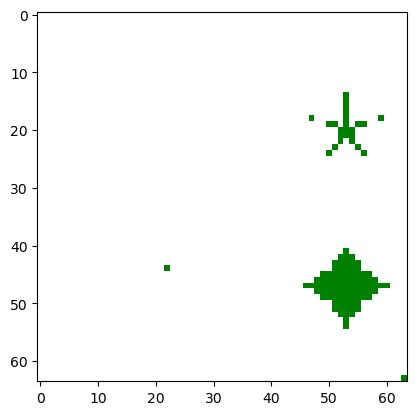

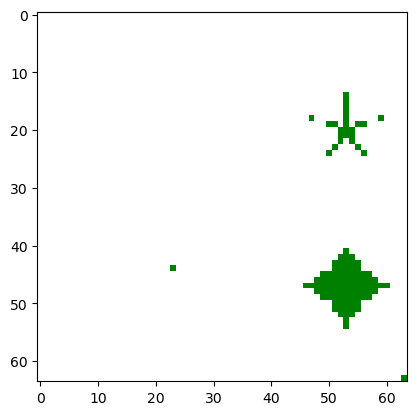

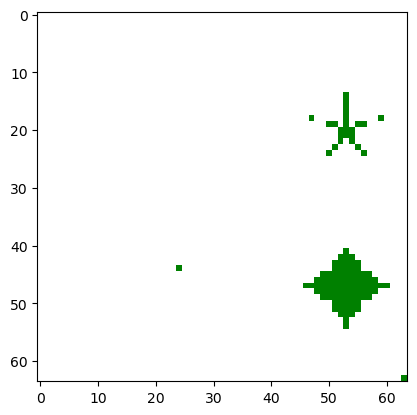

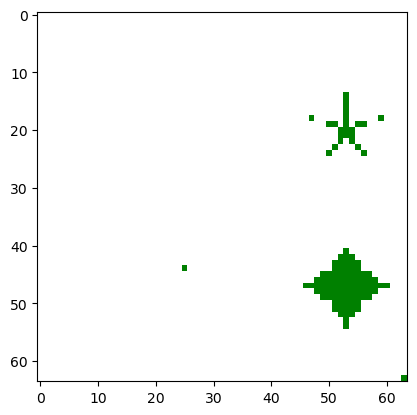

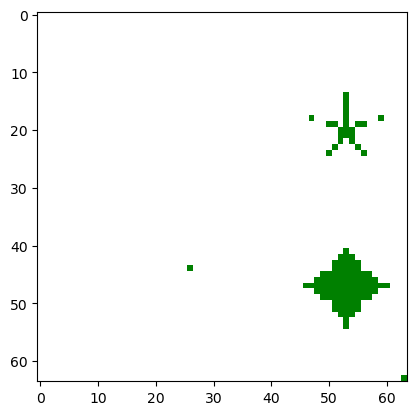

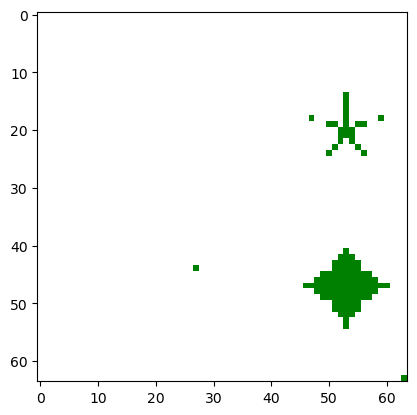

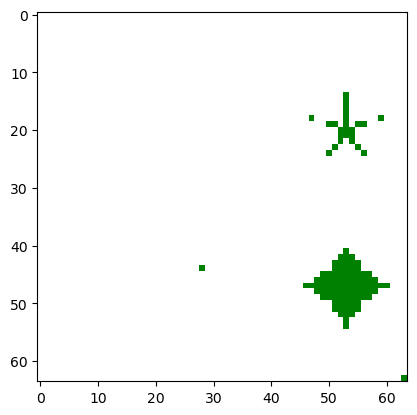

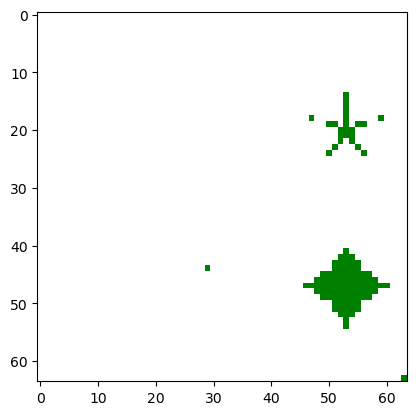

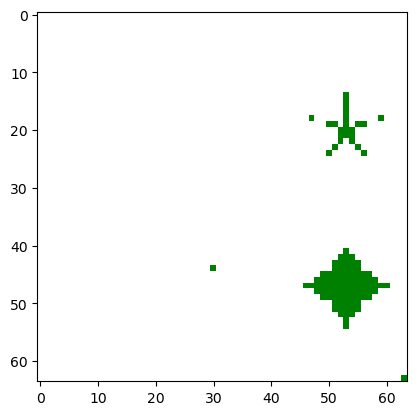

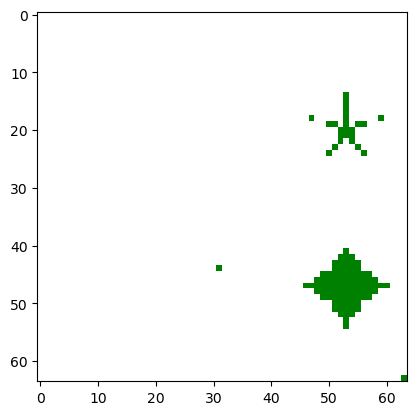

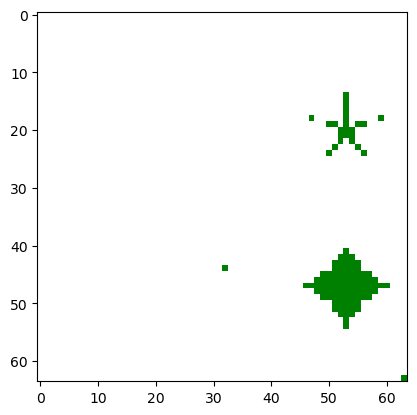

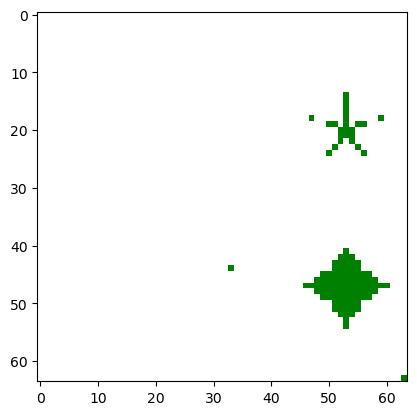

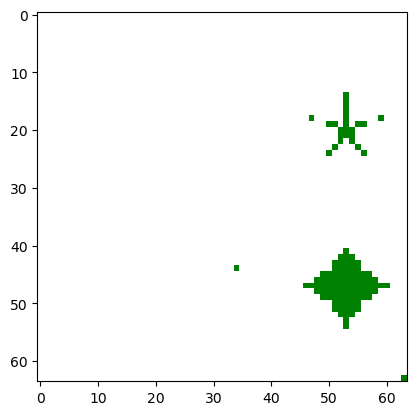

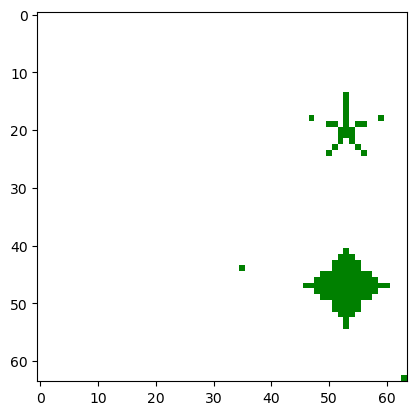

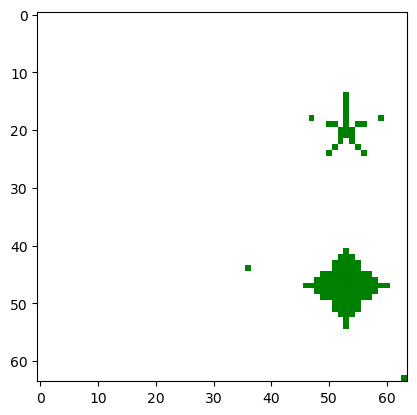

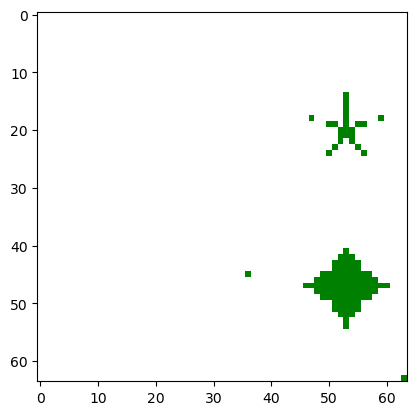

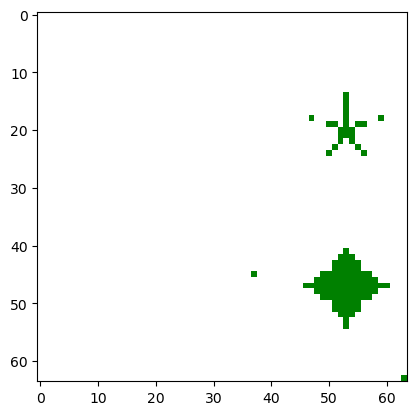

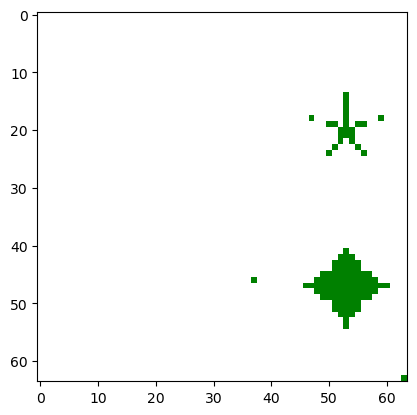

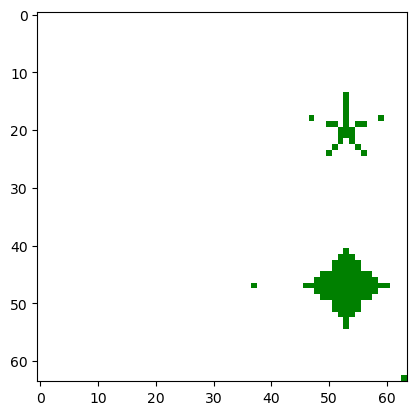

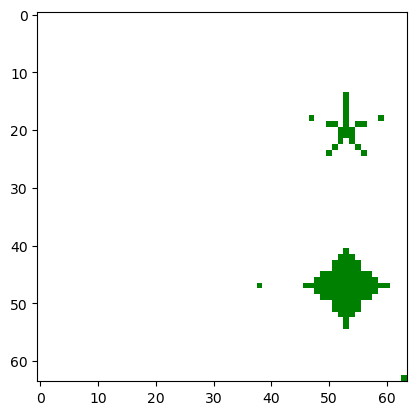

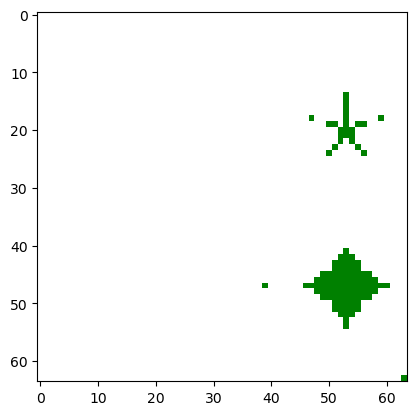

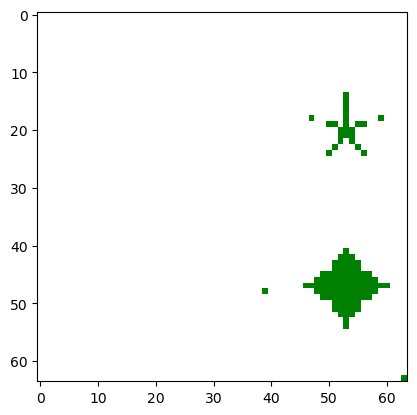

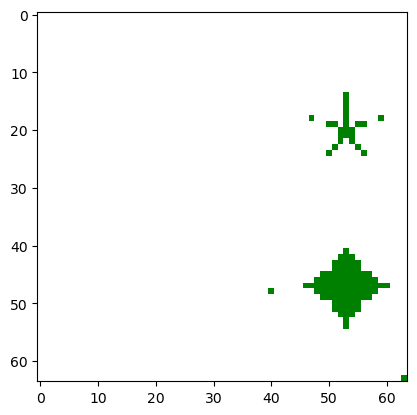

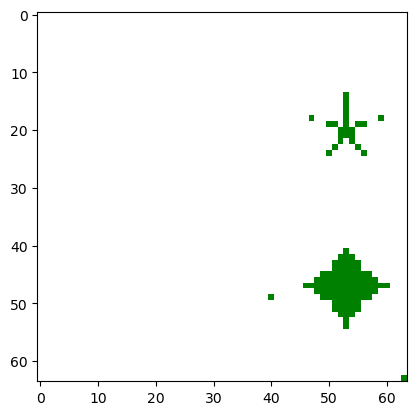

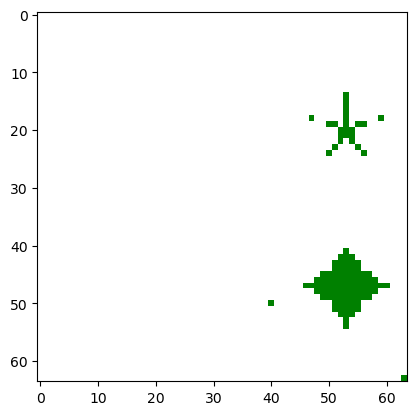

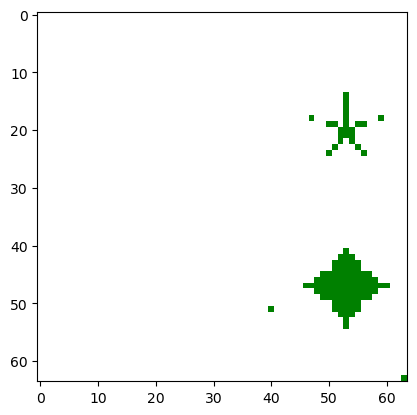

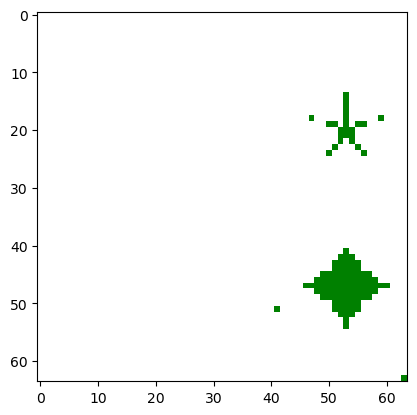

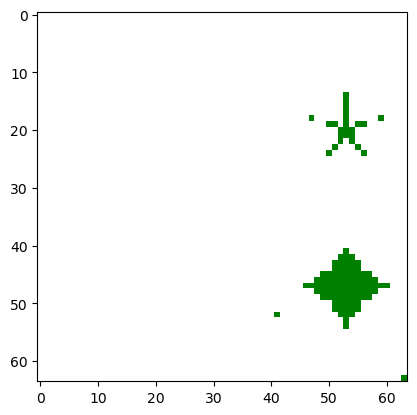

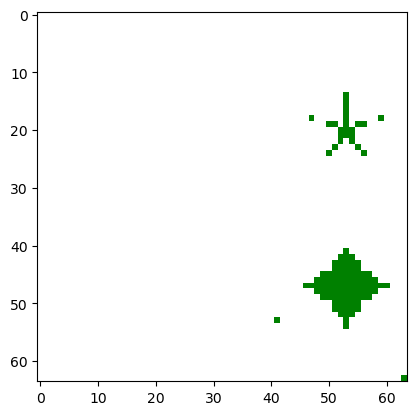

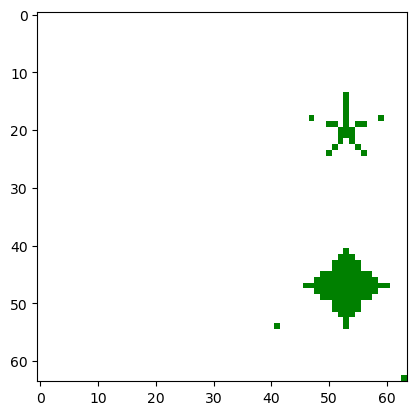

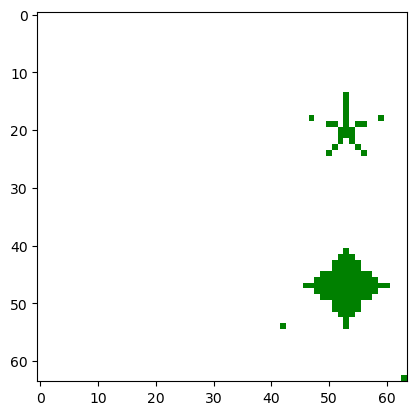

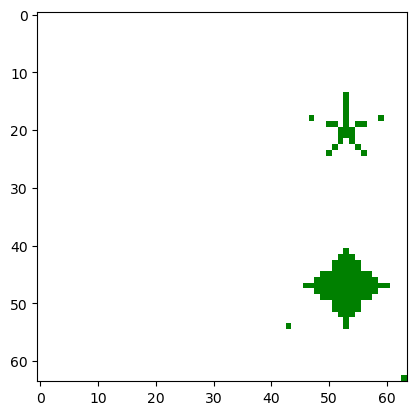

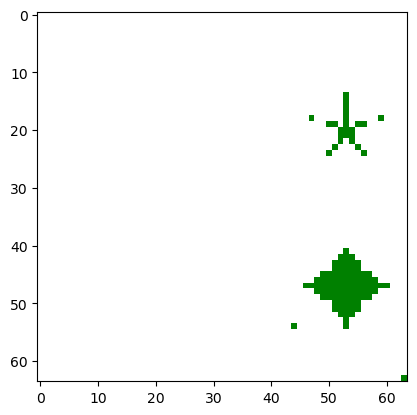

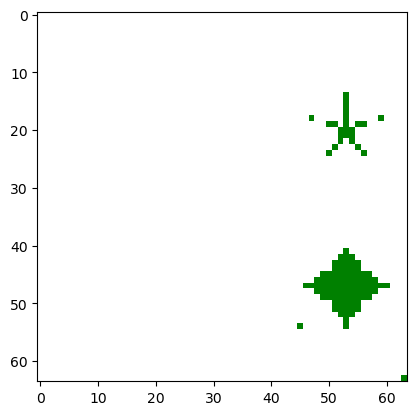

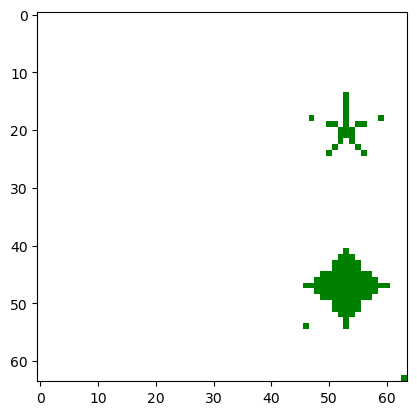

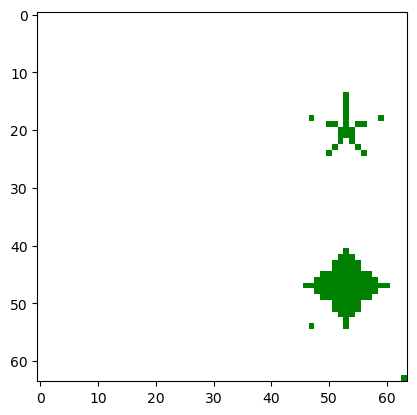

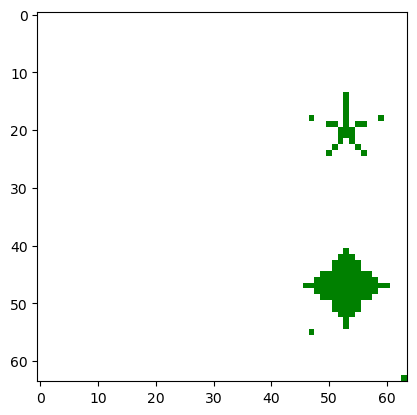

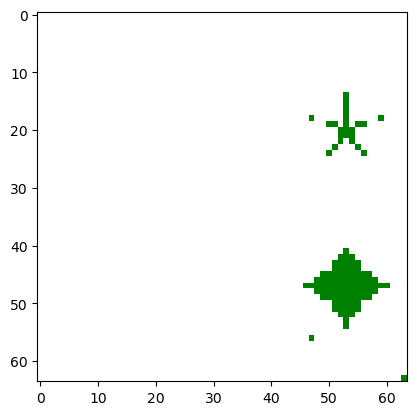

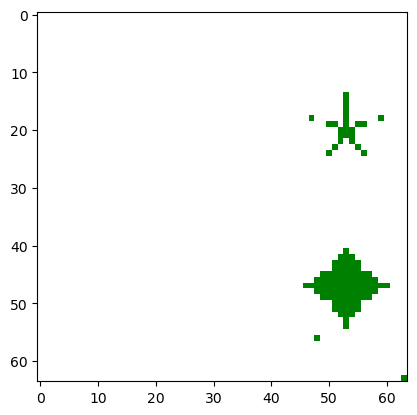

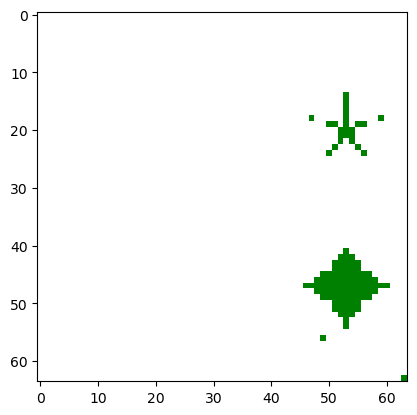

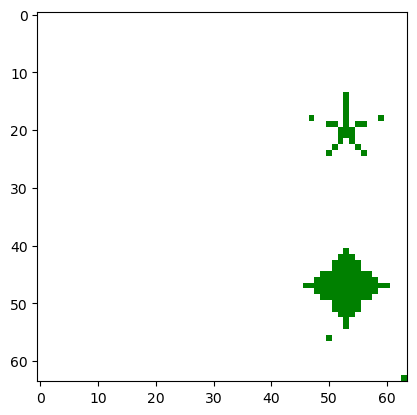

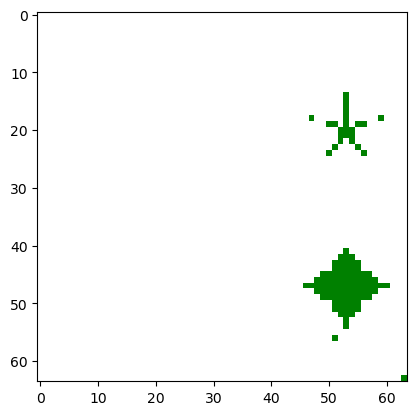

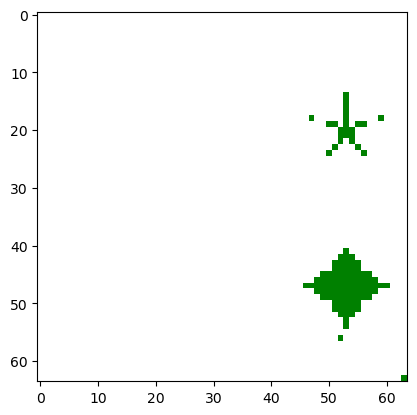

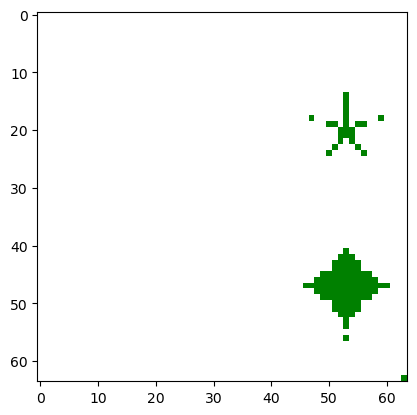

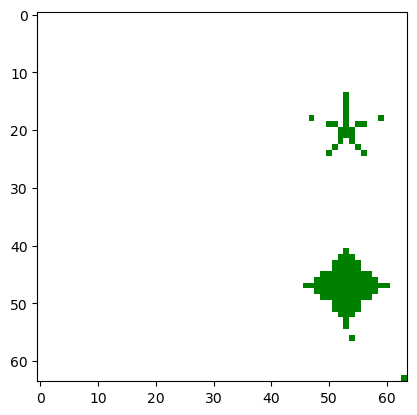

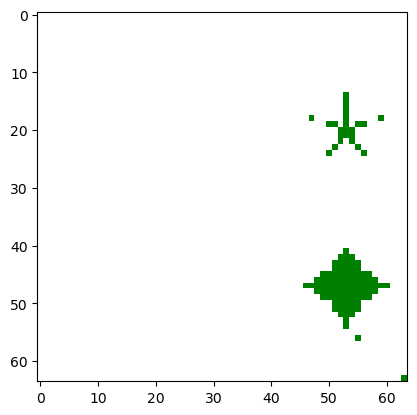

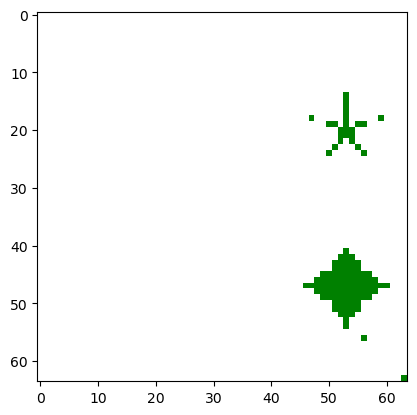

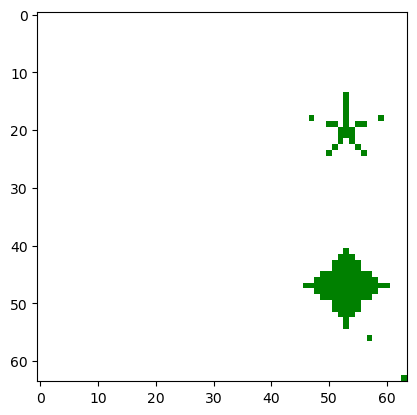

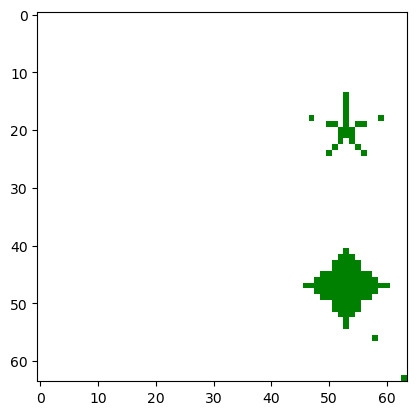

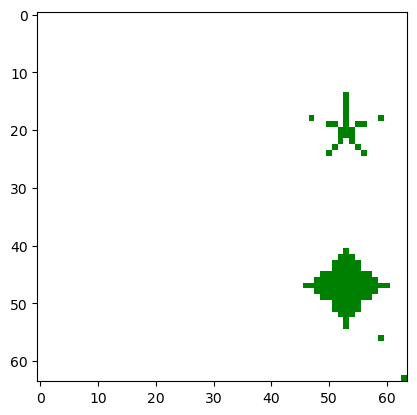

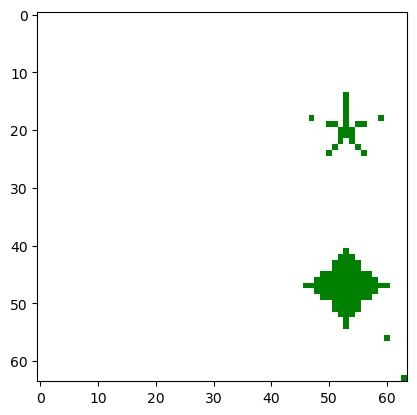

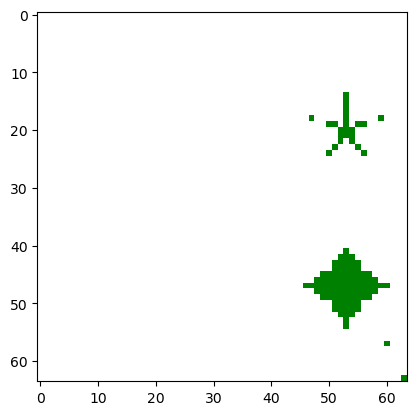

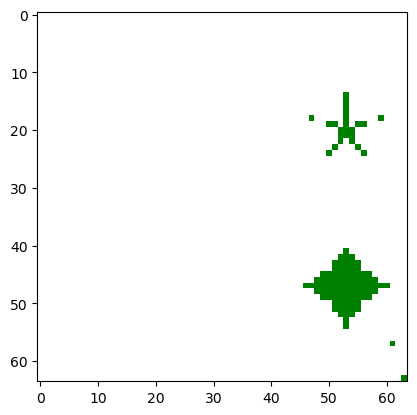

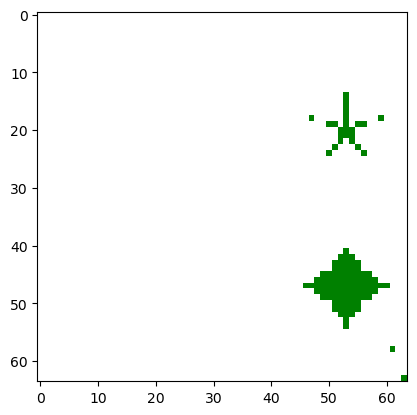

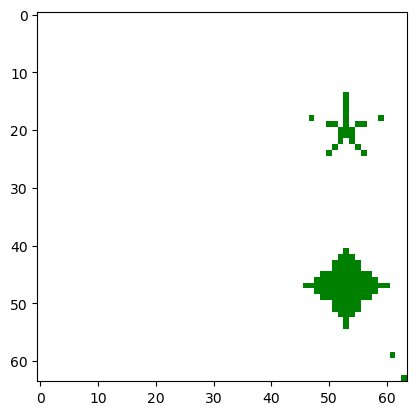

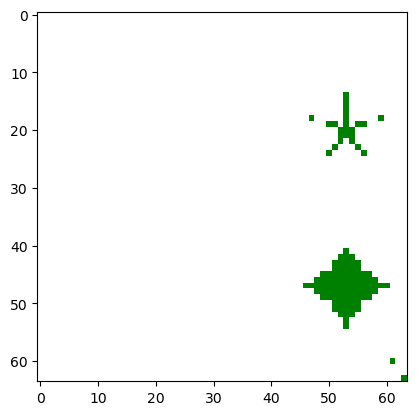

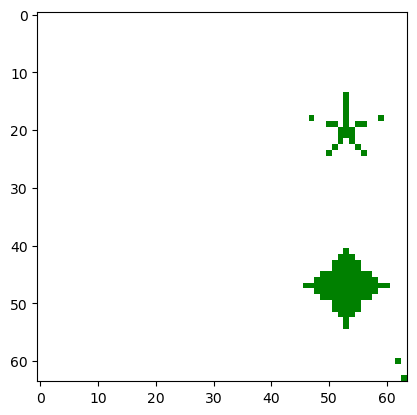

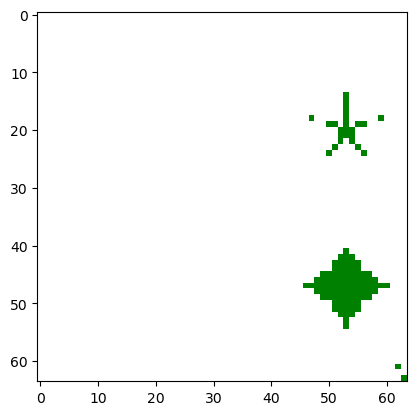

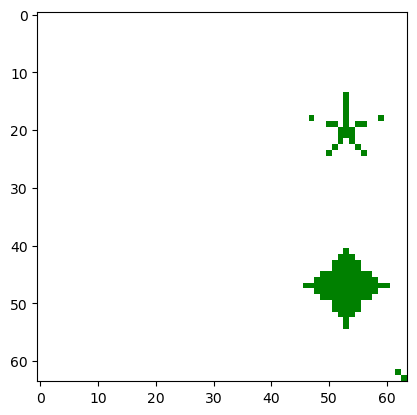

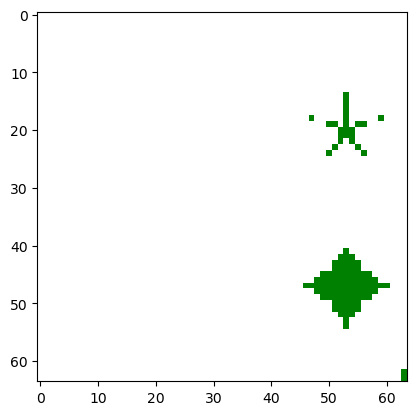

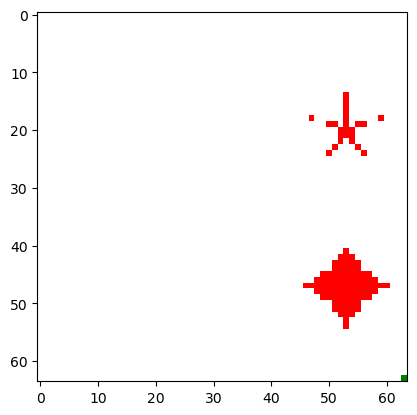

In [59]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

cmap = ListedColormap([
    "white",   # 0
    "black",   # 1
    "red",     # 2
    "green"   # 3
])


start_x = np.random.choice(range(env_size[0]))
start_y = np.random.choice(range(env_size[0]))
start = (start_y, start_x)

max_steps = 1000
goal = (63, 63)

env = GridEnvCNN(grid, start, goal, max_steps)

obs, info = env.reset()  # obs shape: (1, obs_dim)


images = []
plt.imshow(np.sum(obs['image'], axis=0), cmap=cmap)
plt.show()


for i in range(100):
    action, _ = model.predict(obs, deterministic=True)
    
        
    obs, reward, terminated, truncated, info = env.step(action)
    
    plt.imshow(np.sum(obs['image'], axis=0), cmap=cmap)
    plt.show()
    if terminated:
        break

# random start, fixed goal, random environment

(1000, 64, 64)

1.0

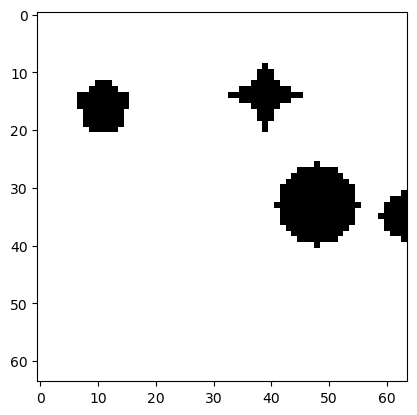

In [ ]:
loaded = np.load('../environment_generation/environments/environments_64_4_1000_1.npy')
print(loaded.shape)

grid = loaded[9]
print(grid.max())
plt.imshow(grid, cmap='binary')

In [ ]:
grid_list = []
for i in loaded:
    grid_list.append(i)

In [90]:
[make_env(grid_list) for _ in range(16)]

[<function __main__.make_env.<locals>._init()>,
 <function __main__.make_env.<locals>._init()>,
 <function __main__.make_env.<locals>._init()>,
 <function __main__.make_env.<locals>._init()>,
 <function __main__.make_env.<locals>._init()>,
 <function __main__.make_env.<locals>._init()>,
 <function __main__.make_env.<locals>._init()>,
 <function __main__.make_env.<locals>._init()>,
 <function __main__.make_env.<locals>._init()>,
 <function __main__.make_env.<locals>._init()>,
 <function __main__.make_env.<locals>._init()>,
 <function __main__.make_env.<locals>._init()>,
 <function __main__.make_env.<locals>._init()>,
 <function __main__.make_env.<locals>._init()>,
 <function __main__.make_env.<locals>._init()>,
 <function __main__.make_env.<locals>._init()>]

In [ ]:
env = DummyVecEnv([make_env(grid_list) for _ in range(16)])
env = VecMonitor(env, filename=None)

model = PPO.load("ppo_custom_cnn_64x64_empty_random_start", env=env, device='cpu')
model.learn(total_timesteps=1_000_000, callback=callback, progress_bar=True)

Output()

In [128]:
model.save("ppo_custom_cnn_64x64_random_env_random_start")

In [129]:
env = DummyVecEnv([make_env(grid_list) for _ in range(16)])
env = VecMonitor(env, filename=None)

model = PPO.load("ppo_custom_cnn_64x64_random_env_random_start", env=env, device='cpu')
model.learn(total_timesteps=500_000, callback=callback, progress_bar=True)

Output()

In [131]:

max_steps = 1000

n = 100
terminated_count = 0
truncated_count = 0
for i in tqdm(range(n)):
    start_x = np.random.choice(range(env_size[0]))
    start_y = np.random.choice(range(env_size[0]))
    start = (start_y, start_x)

    grid = grid_list[np.random.choice(range(len(grid_list)))]
    env = GridEnvCNN(grid, start, goal, max_steps)
    obs, info = env.reset()
    for step in range(env.max_steps):
        action, _ = model.predict(obs, deterministic=True)
        
        obs, reward, terminated, truncated, info = env.step(action)
        
        if terminated or truncated:
            if terminated:
                terminated_count += 1
            elif truncated:
                truncated_count += 1
            break

print('terminated: ', terminated_count/n * 100, '%')

100%|██████████| 100/100 [01:04<00:00,  1.56it/s]

terminated:  23.0 %


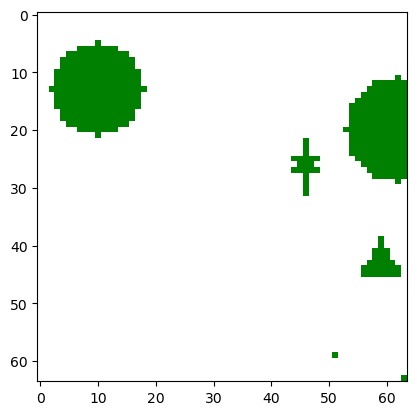

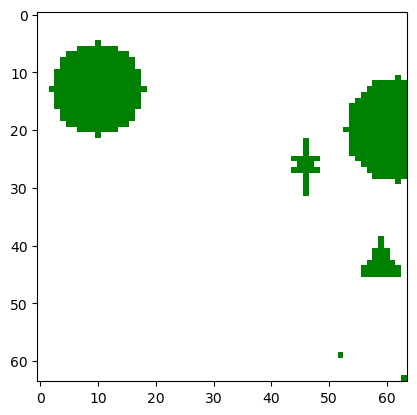

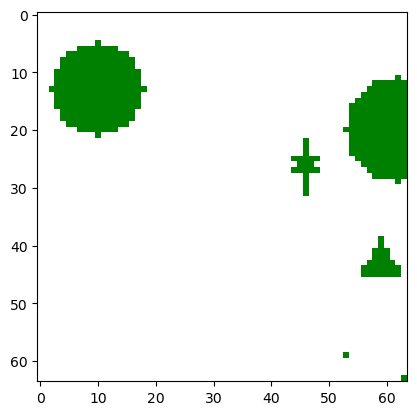

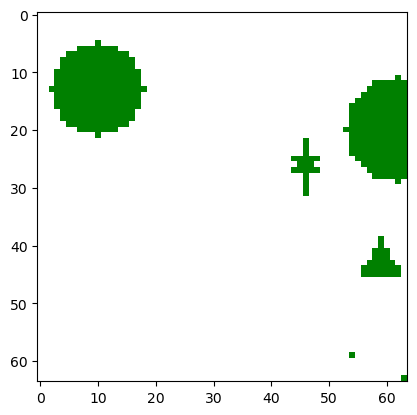

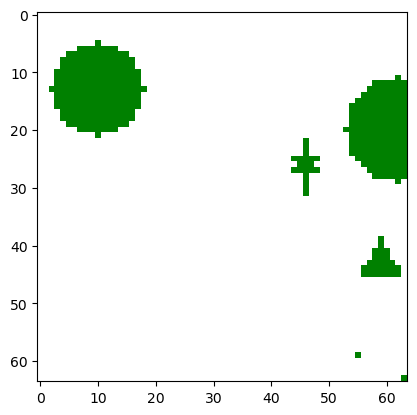

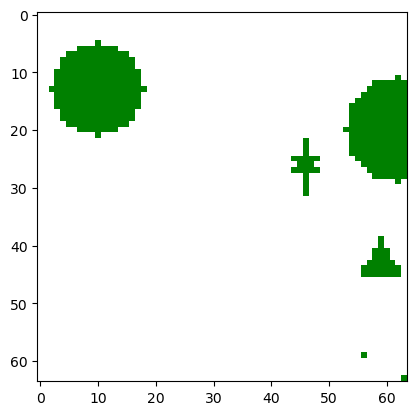

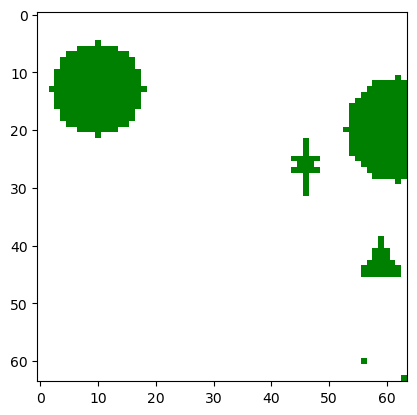

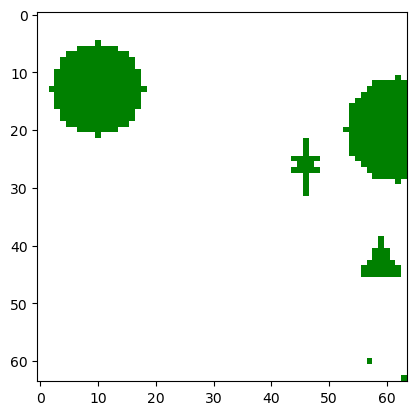

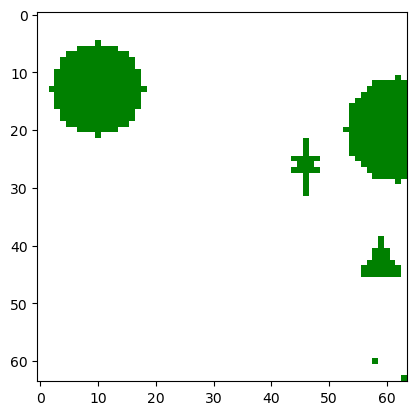

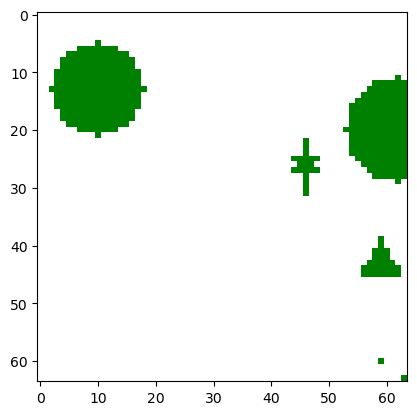

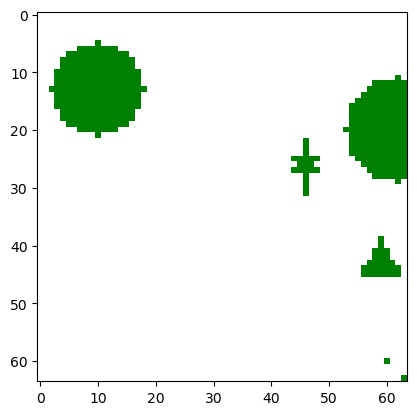

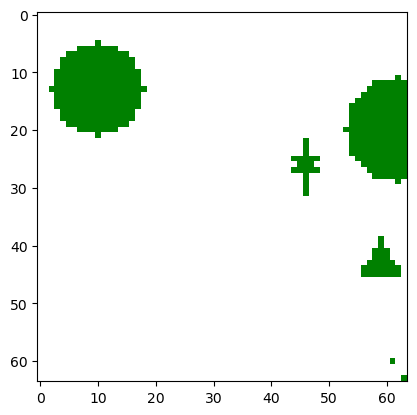

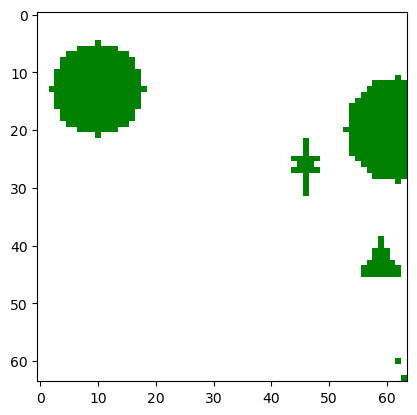

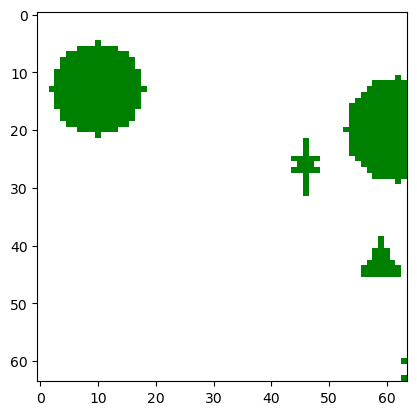

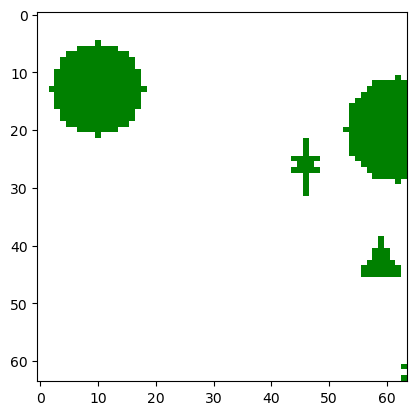

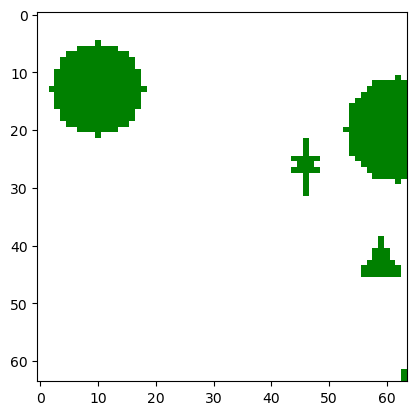

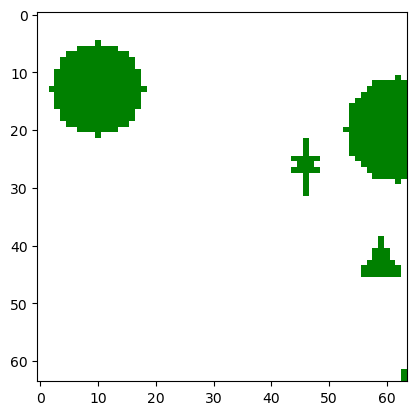

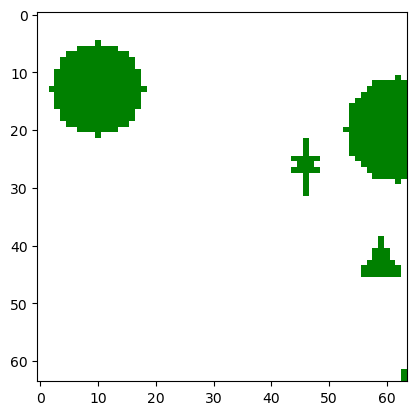

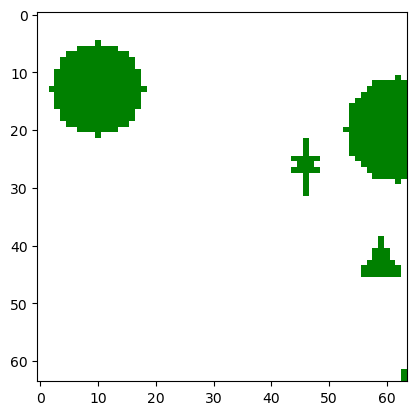

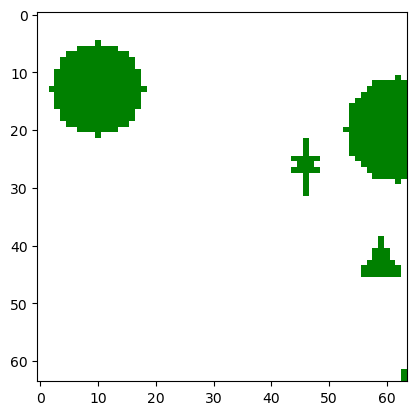

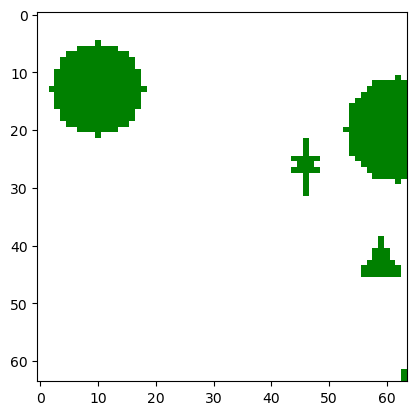

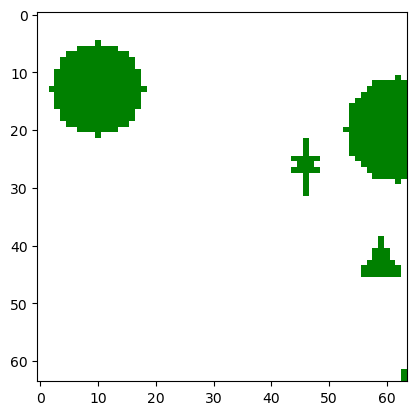

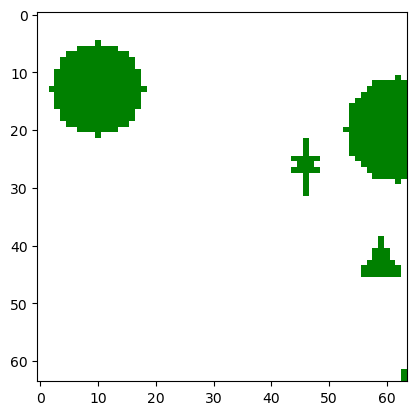

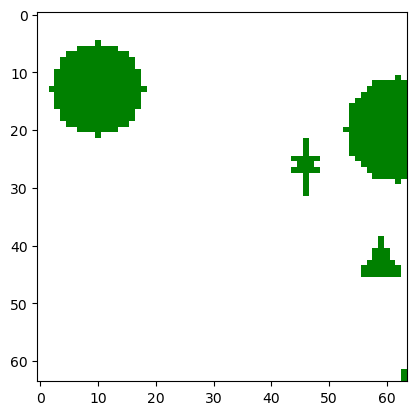

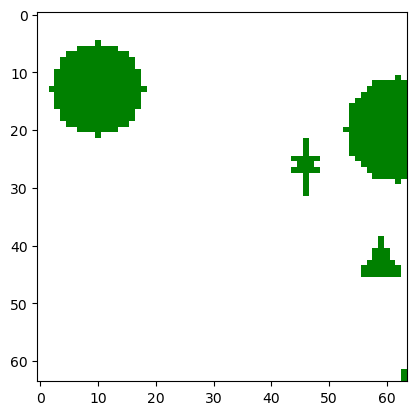

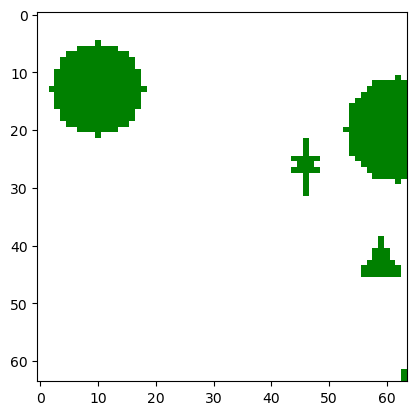

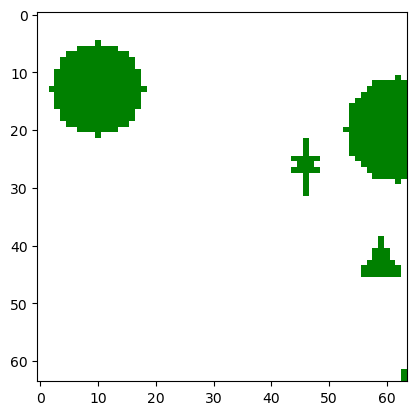

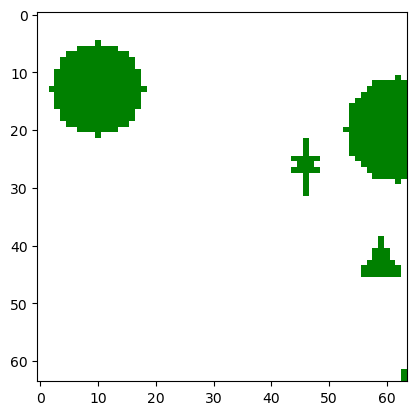

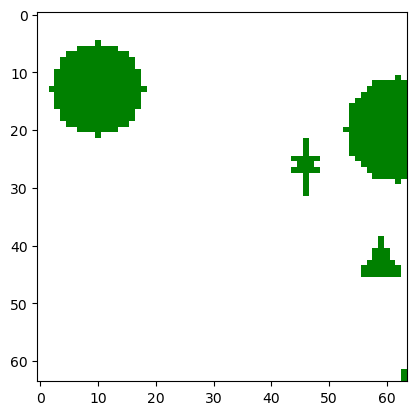

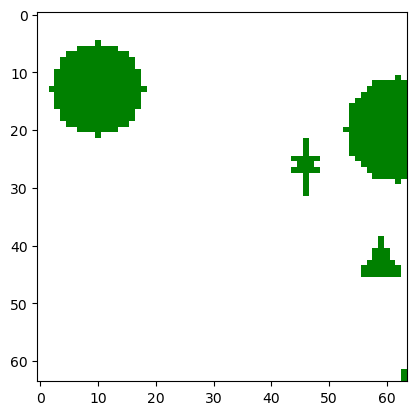

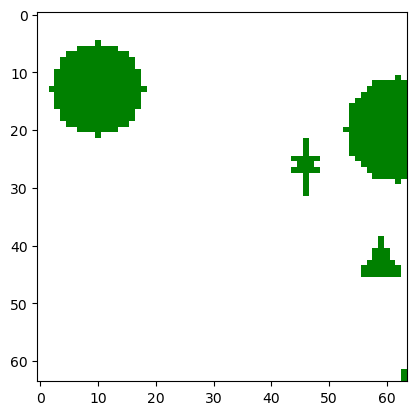

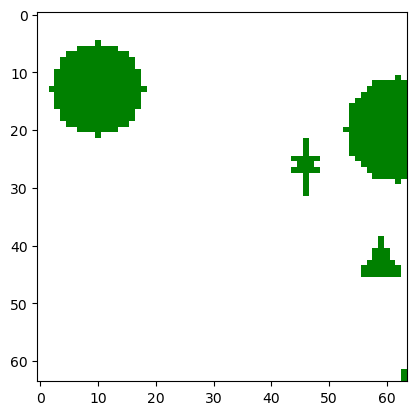

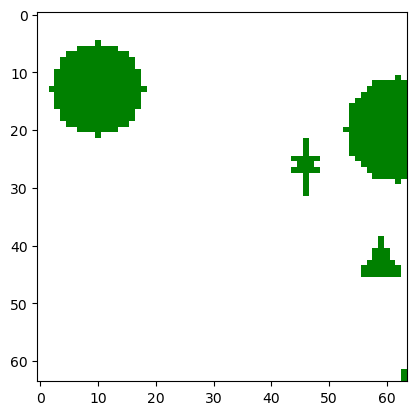

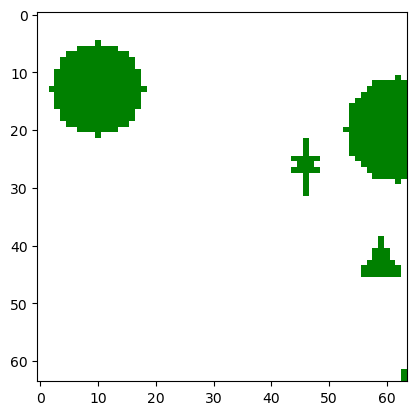

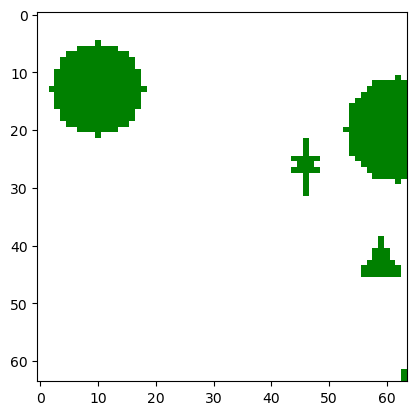

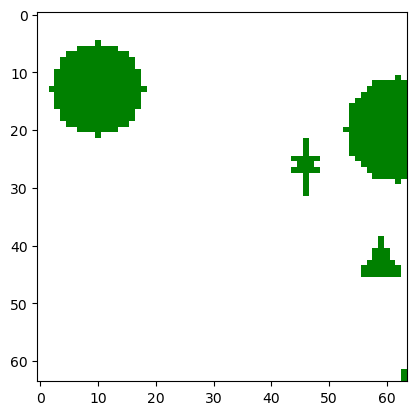

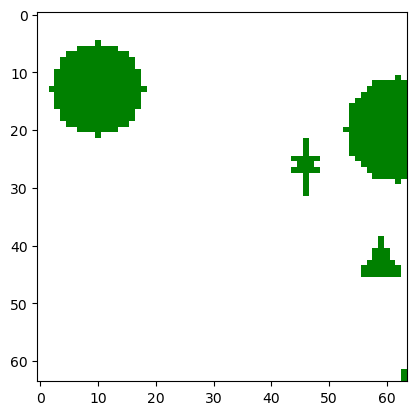

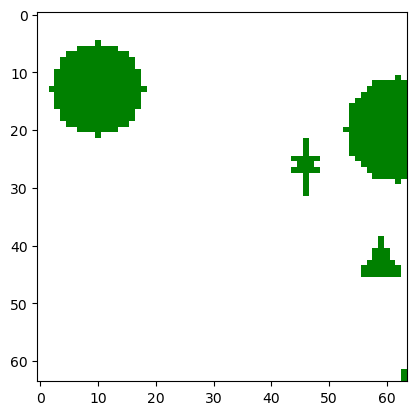

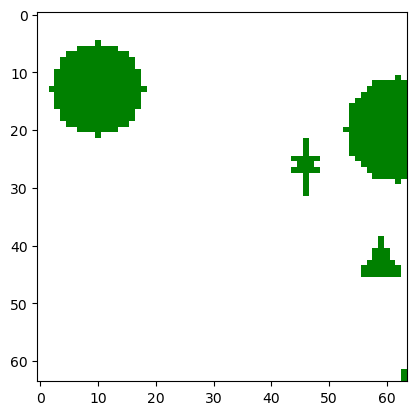

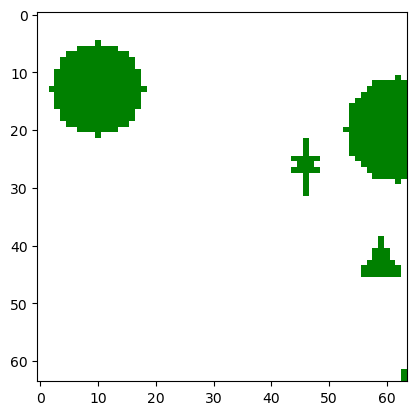

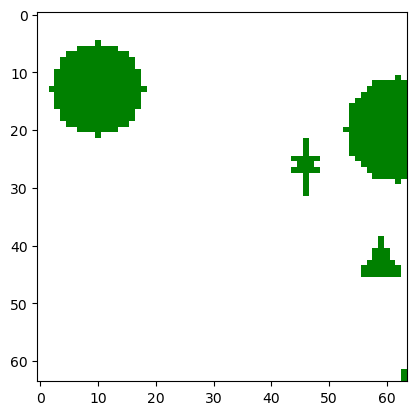

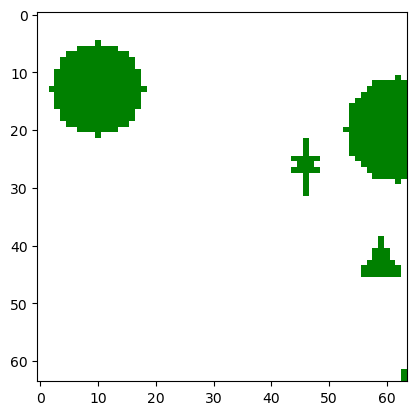

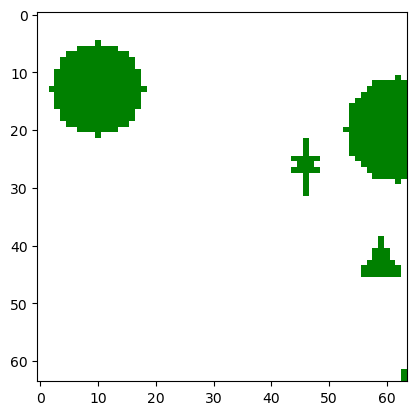

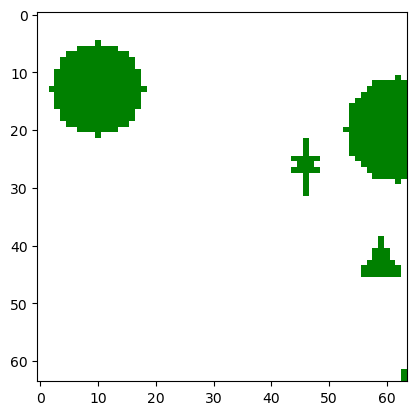

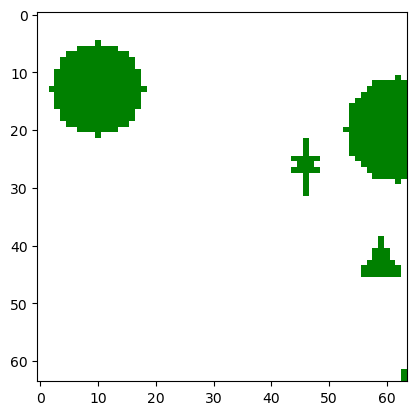

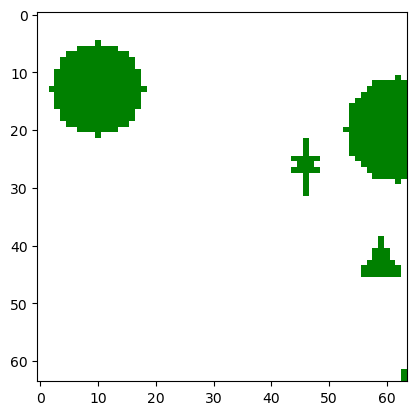

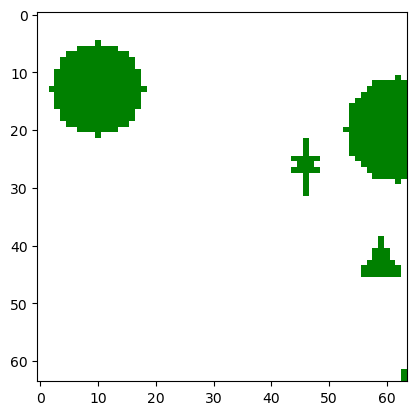

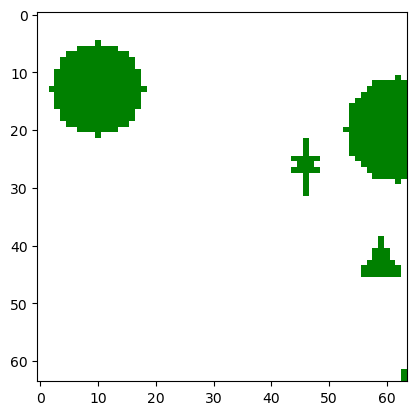

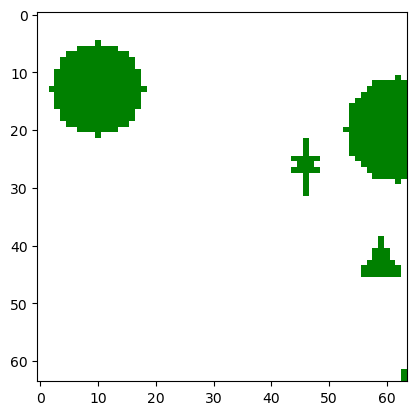

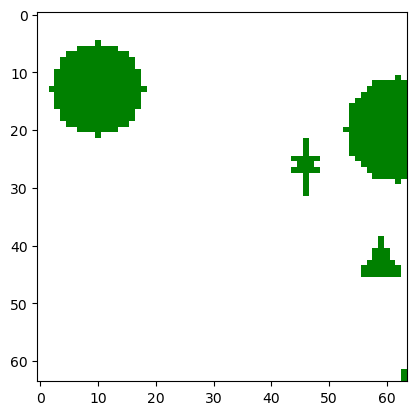

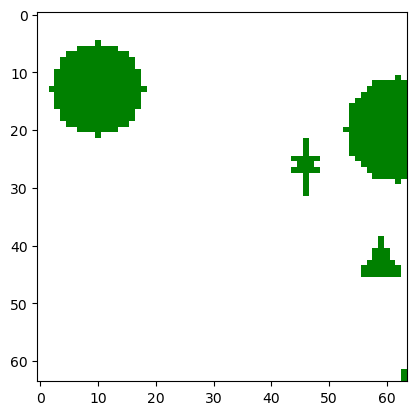

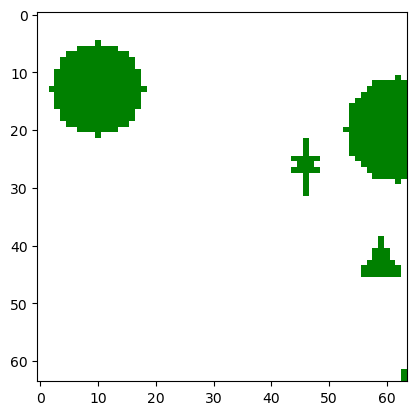

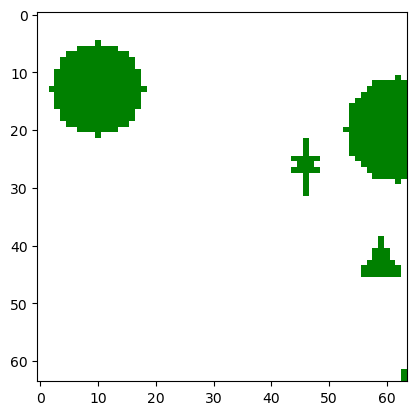

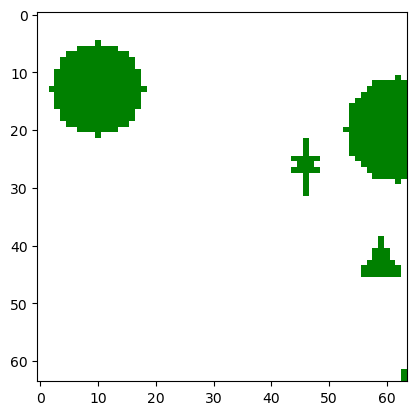

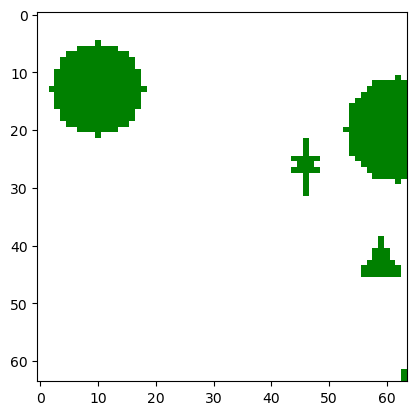

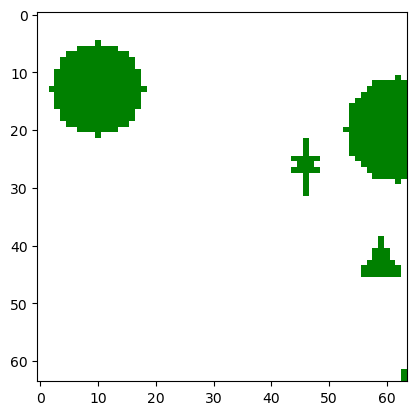

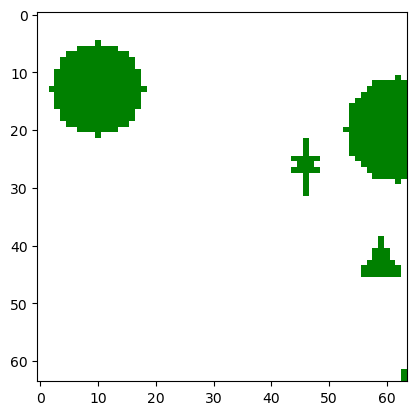

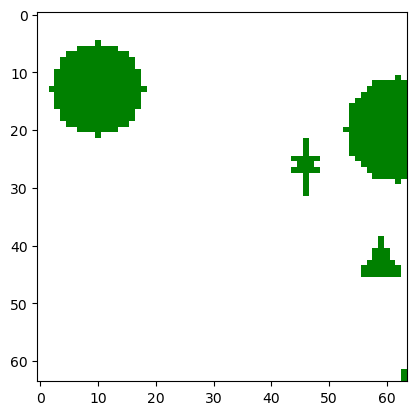

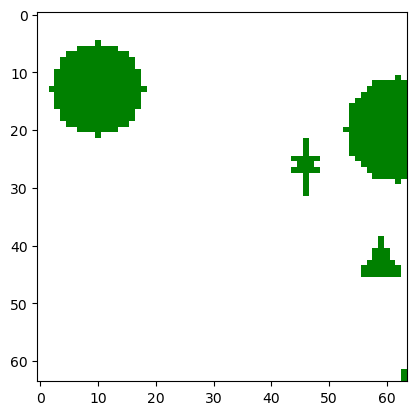

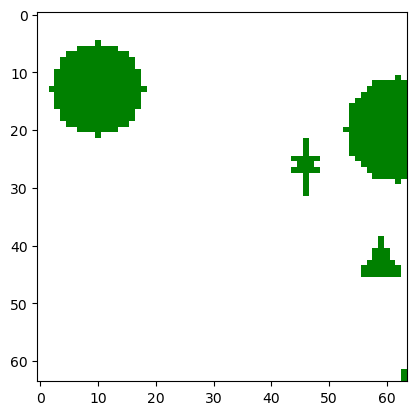

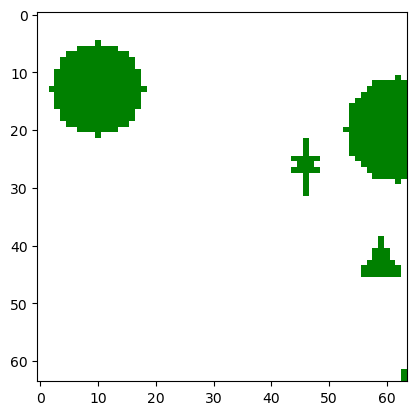

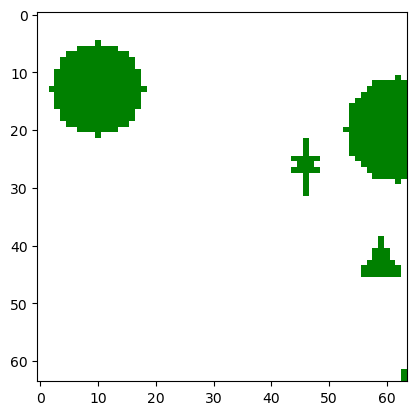

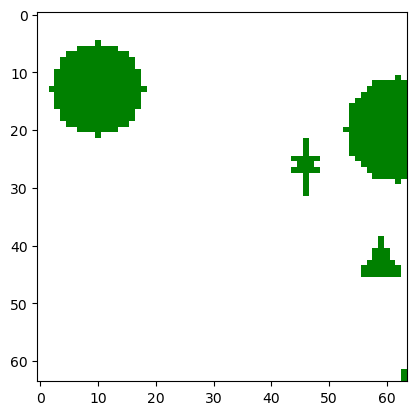

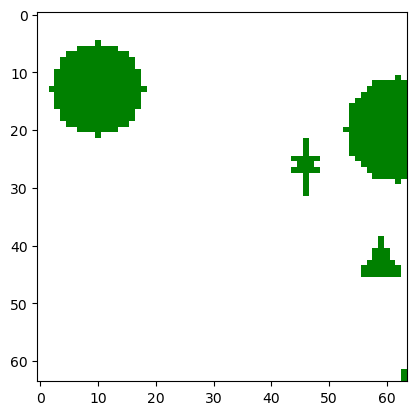

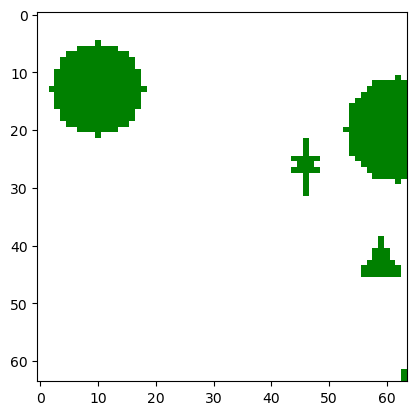

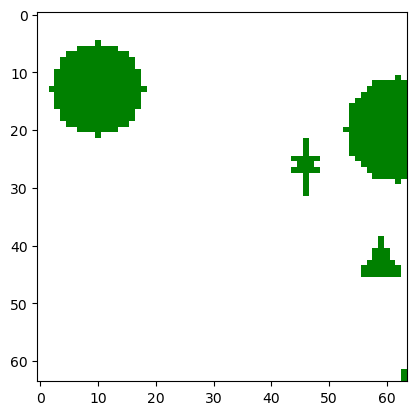

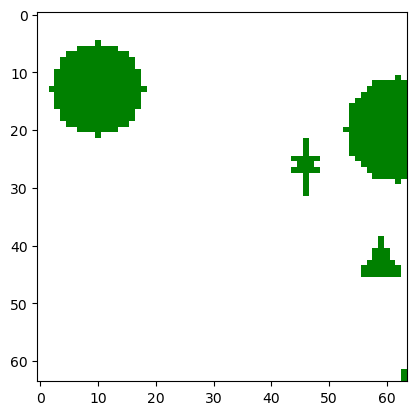

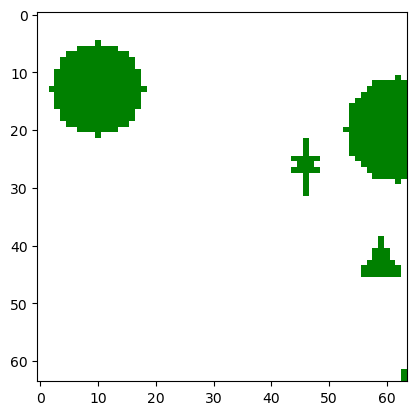

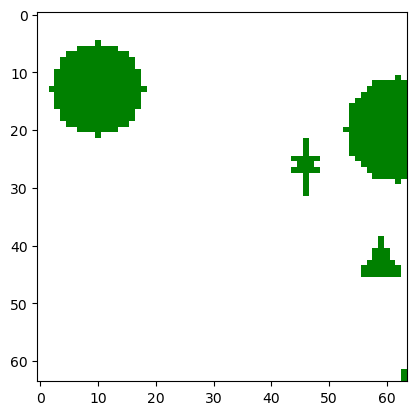

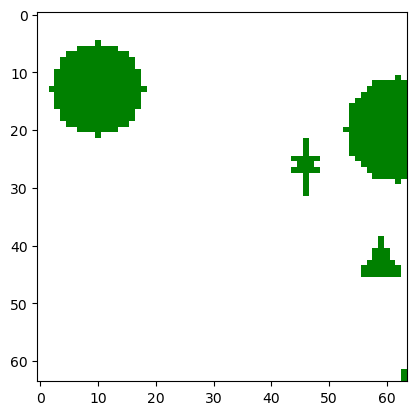

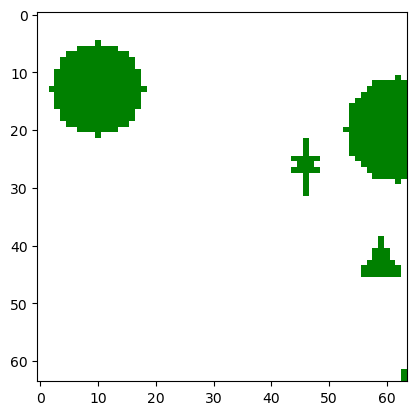

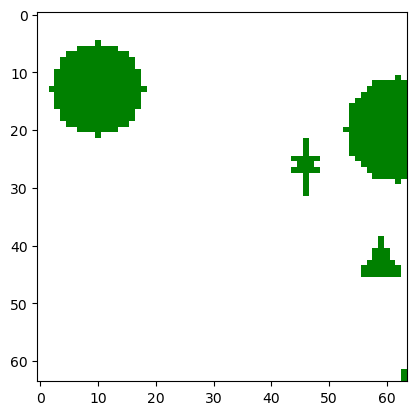

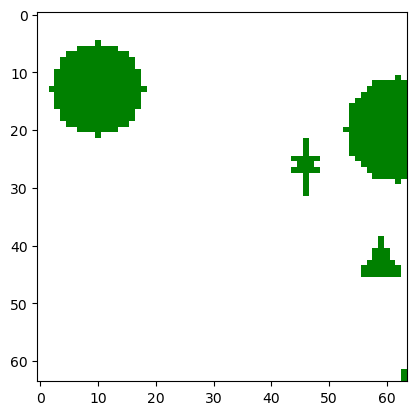

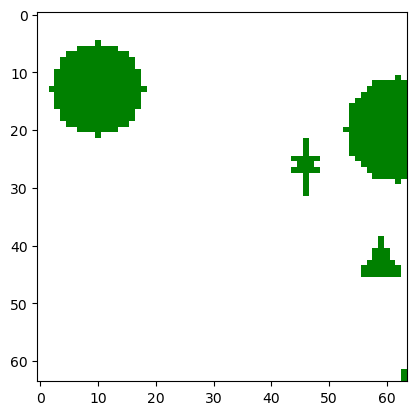

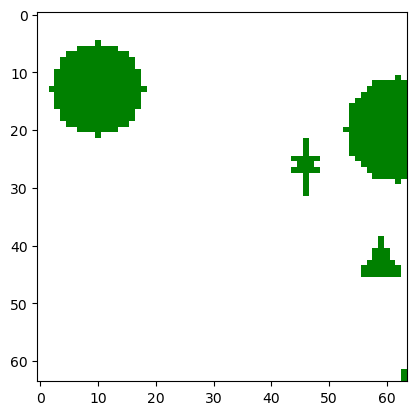

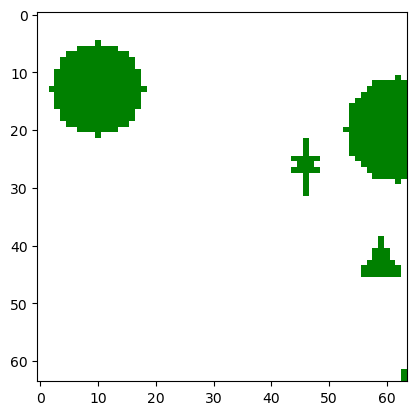

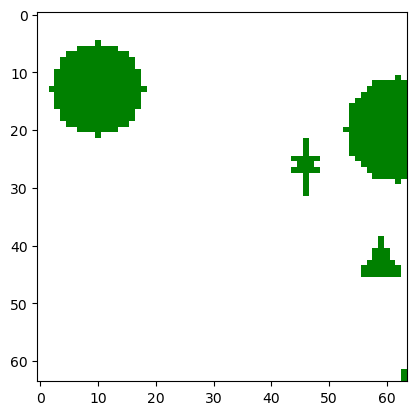

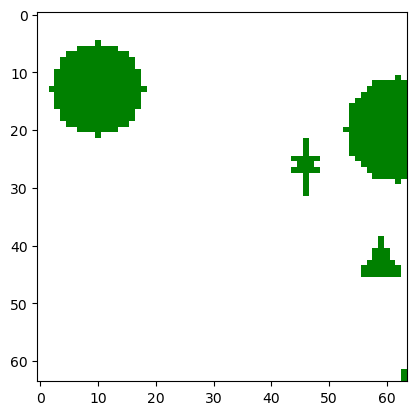

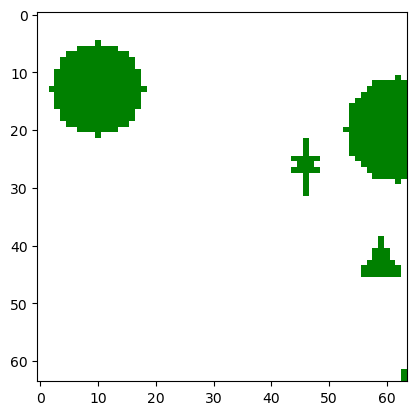

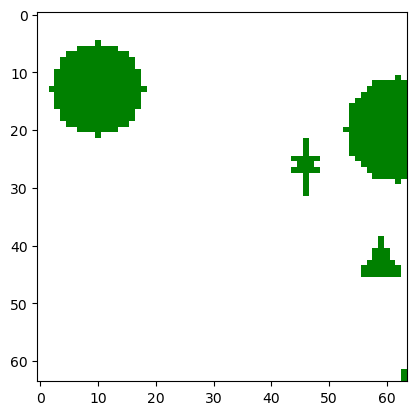

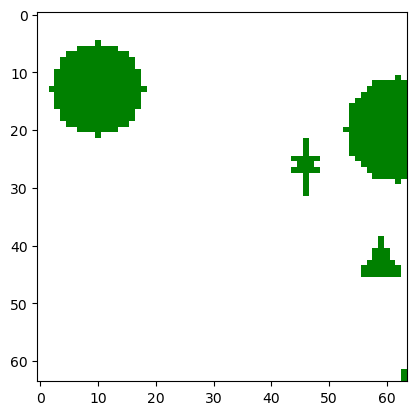

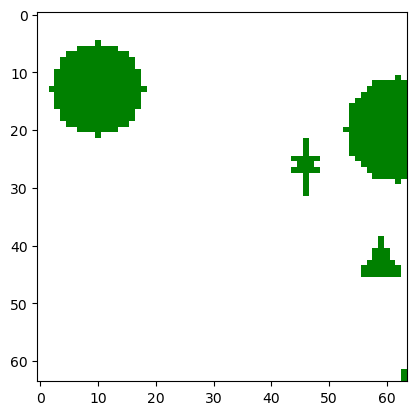

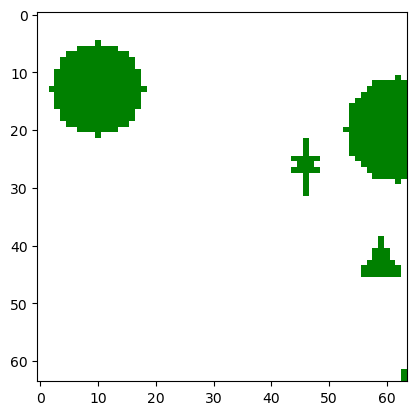

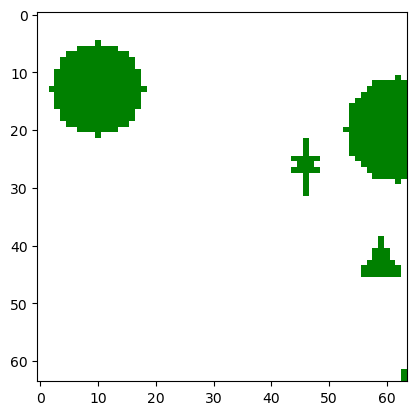

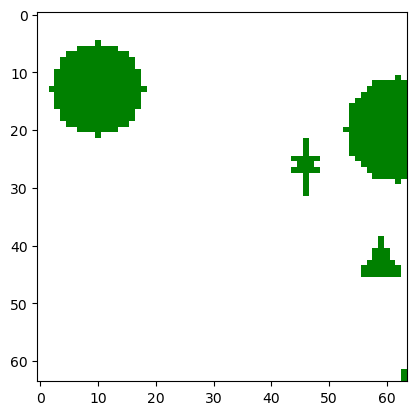

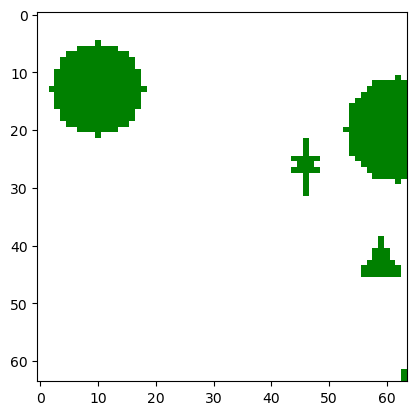

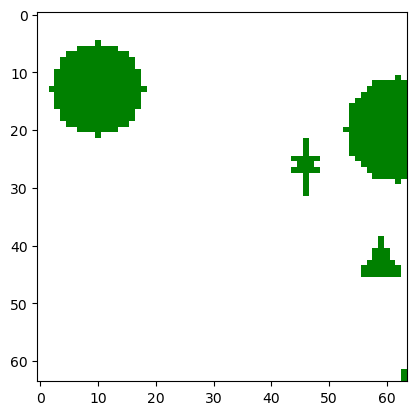

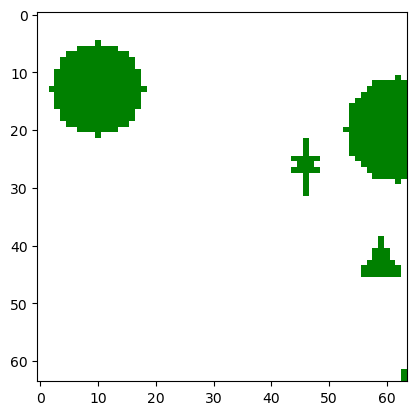

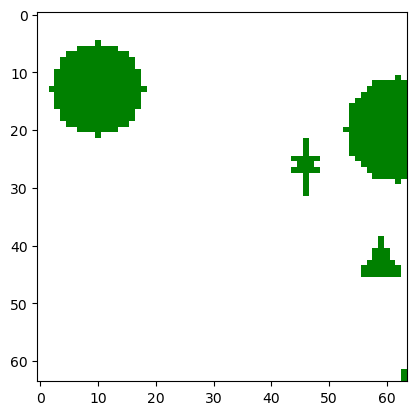

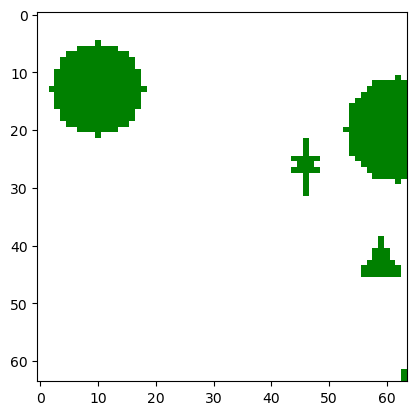

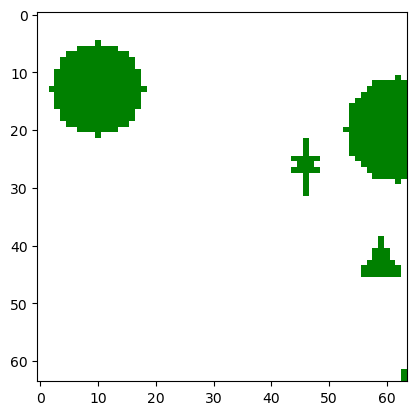

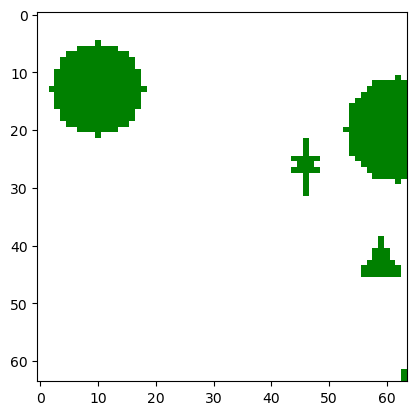

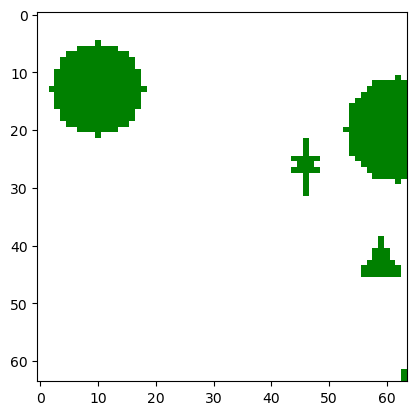

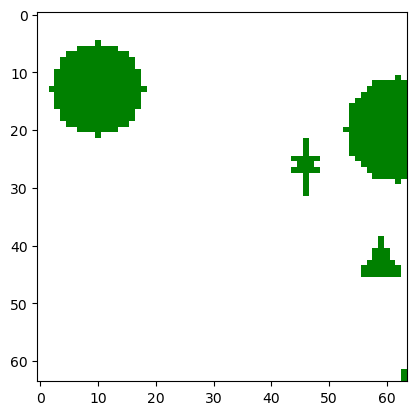

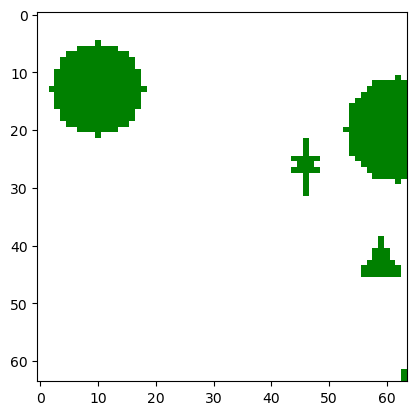

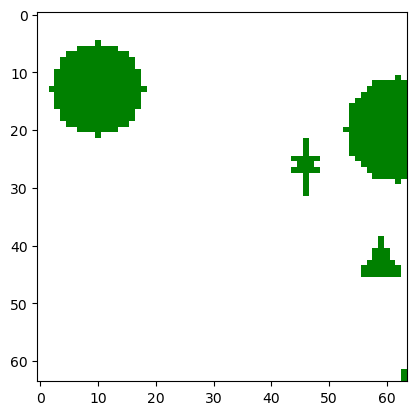

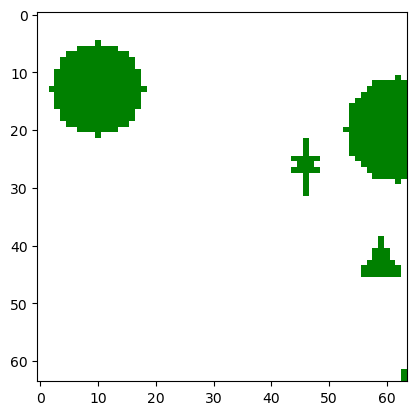

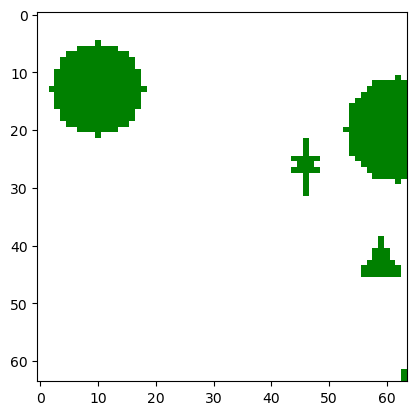

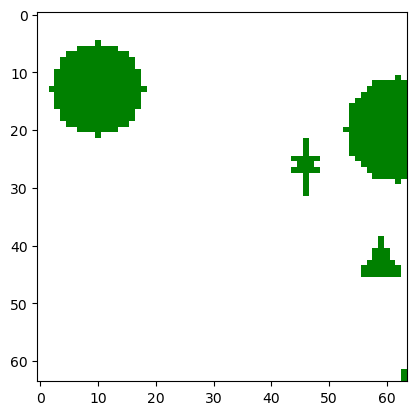

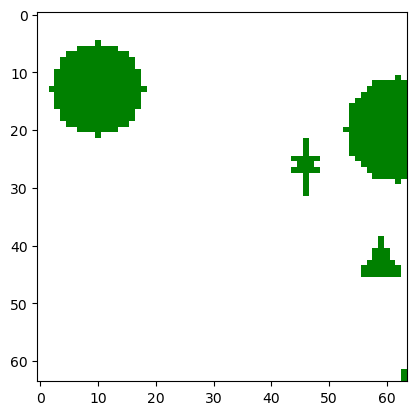

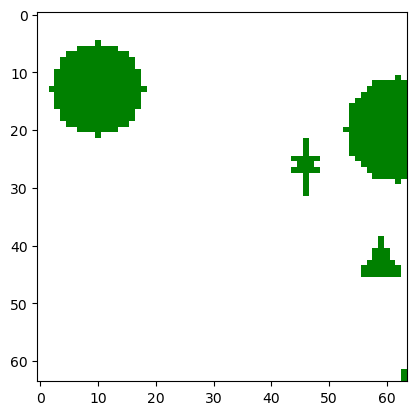

In [130]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

cmap = ListedColormap([
    "white",   # 0
    "black",   # 1
    "red",     # 2
    "green"   # 3
])


start_x = np.random.choice(range(env_size[0]))
start_y = np.random.choice(range(env_size[0]))
start = (start_y, start_x)

max_steps = 1000
goal = (63, 63)

grid = grid_list[np.random.choice(range(len(grid_list)))]
env = GridEnvCNN(grid, start, goal, max_steps)

obs, info = env.reset()  # obs shape: (1, obs_dim)


images = []
plt.imshow(np.sum(obs['image'], axis=0), cmap=cmap)
plt.show()


for i in range(100):
    action, _ = model.predict(obs, deterministic=True)
    
        
    obs, reward, terminated, truncated, info = env.step(action)
    
    plt.imshow(np.sum(obs['image'], axis=0), cmap=cmap)
    plt.show()
    if terminated:
        break